#  Рынок заведений общественного питания Москвы

Инвесторы из фонда «Shut Up and Take My Money» решили попробовать себя в новой области и открыть заведение общественного питания в Москве. Заказчики ещё не знают, что это будет за место: кафе, ресторан, пиццерия, паб или бар, — и какими будут расположение, меню и цены. Задача исследования: найти интересные особенности и презентовать полученные результаты, которые в будущем помогут в выборе подходящего инвесторам места.

Для целей анализа был использован датасет с заведениями общественного питания Москвы, составленный на основе данных сервисов Яндекс Карты и Яндекс Бизнес на лето 2022 года (moscow_places.csv). Информация, размещённая в сервисе Яндекс Бизнес, могла быть добавлена пользователями или найдена в общедоступных источниках. Она носит исключительно справочный характер.

В начале работы вырузим данным и проведем из преобработку. Затем проанализируем доступные чистые данные с целью обнаружения тенденций, особенностей и географической распределенности заведений. С учетом пожеланий заказчиков детальней изучим сегмент кофеен и предоставим рекомендации для открытия нового места.

Результат работы для инвесторов, с выводами по исследованию и обоснованием рекомендаций, будет предоставлен в формате презентации

1. [Загрузка данных и общая информация](#start)
2. [Предобработка данных](#preprocessing)
3. [Анализ рынка](#analise)
    * [Категории заведений](#categtory)
    * [Сетевые заведения](#chain)
    * [Территориальное распределение](#map) 
    * [Дополнительный анализ](#extra) 
    * [Выводы](#results)
4. [Детализация исследования: открытие кофейни](#coffee)
    * [Кофейни Москвы](#coffee_msc)
    * [Рекомендации по открытию](#open_tips)
5. [Заключение](#final)

## Загрузка данных и общая информация <a class="anchor" id="start"></a>

In [1]:
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots
import json
from folium import Map, Choropleth, Marker
from folium.plugins import MarkerCluster
from folium.features import CustomIcon

%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt

In [2]:
display(data.head(3))
display(data.info())

name  category                             address  \
0          WoWфли      кафе          Москва, улица Дыбенко, 7/1   
1  Четыре комнаты  ресторан  Москва, улица Дыбенко, 36, корп. 1   
2           Хазри      кафе      Москва, Клязьминская улица, 15   

                          district  \
0  Северный административный округ   
1  Северный административный округ   
2  Северный административный округ   

                                               hours        lat        lng  \
0                             ежедневно, 10:00–22:00  55.878494  37.478860   
1                             ежедневно, 10:00–22:00  55.875801  37.484479   
2  пн-чт 11:00–02:00; пт,сб 11:00–05:00; вс 11:00...  55.889146  37.525901   

   rating          price                  avg_bill  middle_avg_bill  \
0     5.0            NaN                       NaN              NaN   
1     4.5  выше среднего  Средний счёт:1500–1600 ₽           1550.0   
2     4.6        средние    Средний счёт:от 1000 ₽           1000.0   

   middle_coffee_cup  chain  seats  
0                NaN      0    NaN  
1                NaN      0    4.0  
2                NaN      0   45.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8406 entries, 0 to 8405
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               8406 non-null   object 
 1   category           8406 non-null   object 
 2   address            8406 non-null   object 
 3   district           8406 non-null   object 
 4   hours              7870 non-null   object 
 5   lat                8406 non-null   float64
 6   lng                8406 non-null   float64
 7   rating             8406 non-null   float64
 8   price              3315 non-null   object 
 9   avg_bill           3816 non-null   object 
 10  middle_avg_bill    3149 non-null   float64
 11  middle_coffee_cup  535 non-null    float64
 12  chain              8406 non-null   int64  
 13  seats              4795 non-null   float64
dtypes: float64(6), int64(1), object(7)
memory usage: 919.5+ KB


None

Всего в датасете содержаться данные о 8406 заведениях общепита. Типы данных соответствуют информации, содержащейся в колонках. Заголовки соответствуют правилам хорошего тона. Далее детальней рассмотрим информацию о колонках с пропущенным значением и наличие явных дубликатов и проведем предобработку данных

## Предобработка данных <a class="anchor" id="preprocessing"></a>

Так как некоторое колонки содержат текст и информация могла быть предоставлена пользователем, приведем их к нижнему регистру, чтобы избежать неявных дубликатов. Они могли образоваться при слиянии двух источников: Яндекс Карты и Яндекс Бизнес

In [3]:
data['name'] = data['name'].str.lower()
data['address'] = data['address'].str.lower()
data['avg_bill'] = data['avg_bill'].str.lower()

In [4]:
columns_with_miss = data.isna().sum()
columns_with_miss = columns_with_miss[columns_with_miss!=0]
print ('Колонок с пропущенным значением:', len(columns_with_miss))
columns_with_miss.sort_values(ascending=False)
print ('Количество явных дубликатов:', data.duplicated().sum())
print('Количество уникальных наименований:',data['name'].nunique()) 

Колонок с пропущенным значением: 6
Количество явных дубликатов: 0
Количество уникальных наименований: 5512


In [5]:
columns_with_miss.sort_values(ascending=False)

middle_coffee_cup    7871
middle_avg_bill      5257
price                5091
avg_bill             4590
seats                3611
hours                 536
dtype: int64

Явных дубликатов не обнаружено. В датасете 5512 уникальных наименования заведения, из 8406 строк. Скорей всего это связано с тем, что часть заведений являются сетевыми. Их мы рассмотрим позднее в ходе анализа

Первые 4 строки с наибольшим количством пропусков занимают колонки, так или иначе связанные с ценой. 

Самое большое количество пропусков находится в колонке middle_coffee_cup основанной на данных из avg_bill. В него входят только те суммы, которые начинаются с подстроки «Цена одной чашки капучино».

Следом большое количество пропусков находится в колонке middle_avg_bill основанной на данных из avg_bill. В него входят только те суммы, которые начинаются с подстроки «Средний счёт».

Колонки price и avg_bill типа object и содежат информацию о среднем чеке и ценовом сегменте. 

**Так как эти колонки отображают стоимость и связаны с ценовой политикой заведения заполнять пропуски не целесообразно, они не будут отражать реальную картину рынка**

Можно предположить, что пропуски в количестве мест (seats) связаны с тем, что заведение работает на вынос, но пропуски составляют почти половину от всех данных. Слишком большой риск искажения информации, если они будут заполненны нулями.

Тоже самое касается часов работы. График работы унифицировать для всех заведений мы не можем. 

Добавим в таблицу два столбца, которые позже помогут с анализом рынка:
* столбец street с названиями улиц из столбца с адресом.
* столбец is_24/7 с обозначением, что заведение работает ежедневно и круглосуточно (24/7):

In [6]:
data['is_24_7'] = data['hours'].str.contains('ежедневно, круглосуточно')
data['is_24_7'] = data['is_24_7'].fillna(False)

In [7]:
data['street']=[x.split(',')[1] for x in data['address'].values]

In [8]:
data.head()

name  category                              address  \
0                wowфли      кафе           москва, улица дыбенко, 7/1   
1        четыре комнаты  ресторан   москва, улица дыбенко, 36, корп. 1   
2                 хазри      кафе       москва, клязьминская улица, 15   
3  dormouse coffee shop   кофейня  москва, улица маршала федоренко, 12   
4             иль марко  пиццерия      москва, правобережная улица, 1б   

                          district  \
0  Северный административный округ   
1  Северный административный округ   
2  Северный административный округ   
3  Северный административный округ   
4  Северный административный округ   

                                               hours        lat        lng  \
0                             ежедневно, 10:00–22:00  55.878494  37.478860   
1                             ежедневно, 10:00–22:00  55.875801  37.484479   
2  пн-чт 11:00–02:00; пт,сб 11:00–05:00; вс 11:00...  55.889146  37.525901   
3                             ежедневно, 09:00–22:00  55.881608  37.488860   
4                             ежедневно, 10:00–22:00  55.881166  37.449357   

   rating          price                       avg_bill  middle_avg_bill  \
0     5.0            NaN                            NaN              NaN   
1     4.5  выше среднего       средний счёт:1500–1600 ₽           1550.0   
2     4.6        средние         средний счёт:от 1000 ₽           1000.0   
3     5.0            NaN  цена чашки капучино:155–185 ₽              NaN   
4     5.0        средние         средний счёт:400–600 ₽            500.0   

   middle_coffee_cup  chain  seats  is_24_7                    street  
0                NaN      0    NaN    False             улица дыбенко  
1                NaN      0    4.0    False             улица дыбенко  
2                NaN      0   45.0    False        клязьминская улица  
3              170.0      0    NaN    False   улица маршала федоренко  
4                NaN      1  148.0    False       правобережная улица

## Анализ рынка <a class="anchor" id="analise"></a>

### Категории заведений  <a class="anchor" id="categtory"></a>

In [9]:
data['category'].unique()

array(['кафе', 'ресторан', 'кофейня', 'пиццерия', 'бар,паб',
       'быстрое питание', 'булочная', 'столовая'], dtype=object)

Всего в исследовании представленны 8 категорий предприятий общепита. Не смотря на то, что кафе и кофейня могут быть похожими словами по смыслу, в классификации заведений общественного питания они разделены (https://restoplace.cc/blog/zavedeniya-horeca#rec520577366). Оставим категории в том виде, в котром они есть 

Посмотрим что чаще всего встречается в Москве, построив диаграмму

In [10]:
type = data.groupby('category', as_index=False)['rating'].count().sort_values(by='rating', ascending=False)
type = type.rename(columns={'rating':'total'})

In [11]:
# строим столбчатую диаграмму 
fig = px.bar(type.sort_values(by='total', ascending=True), # загружаем данные и заново их сортируем
             x='total', # указываем столбец с данными для оси X
             y='category', # указываем столбец с данными для оси Y
             text='total'
                                       
            )
# оформляем график
fig.update_layout(title='Распределение заведений общепита по категориям',
                   xaxis_title='Количество заведений',
                   yaxis_title='Категория')
fig.show() # выводим график

Топ 3 заведений составляют:
* Кафе
* Ресторан
* Кофейни

По всей Москве реже всего встречаются столовые и булочные.

Посмотрим распределение посадочных мест по категориям заведений

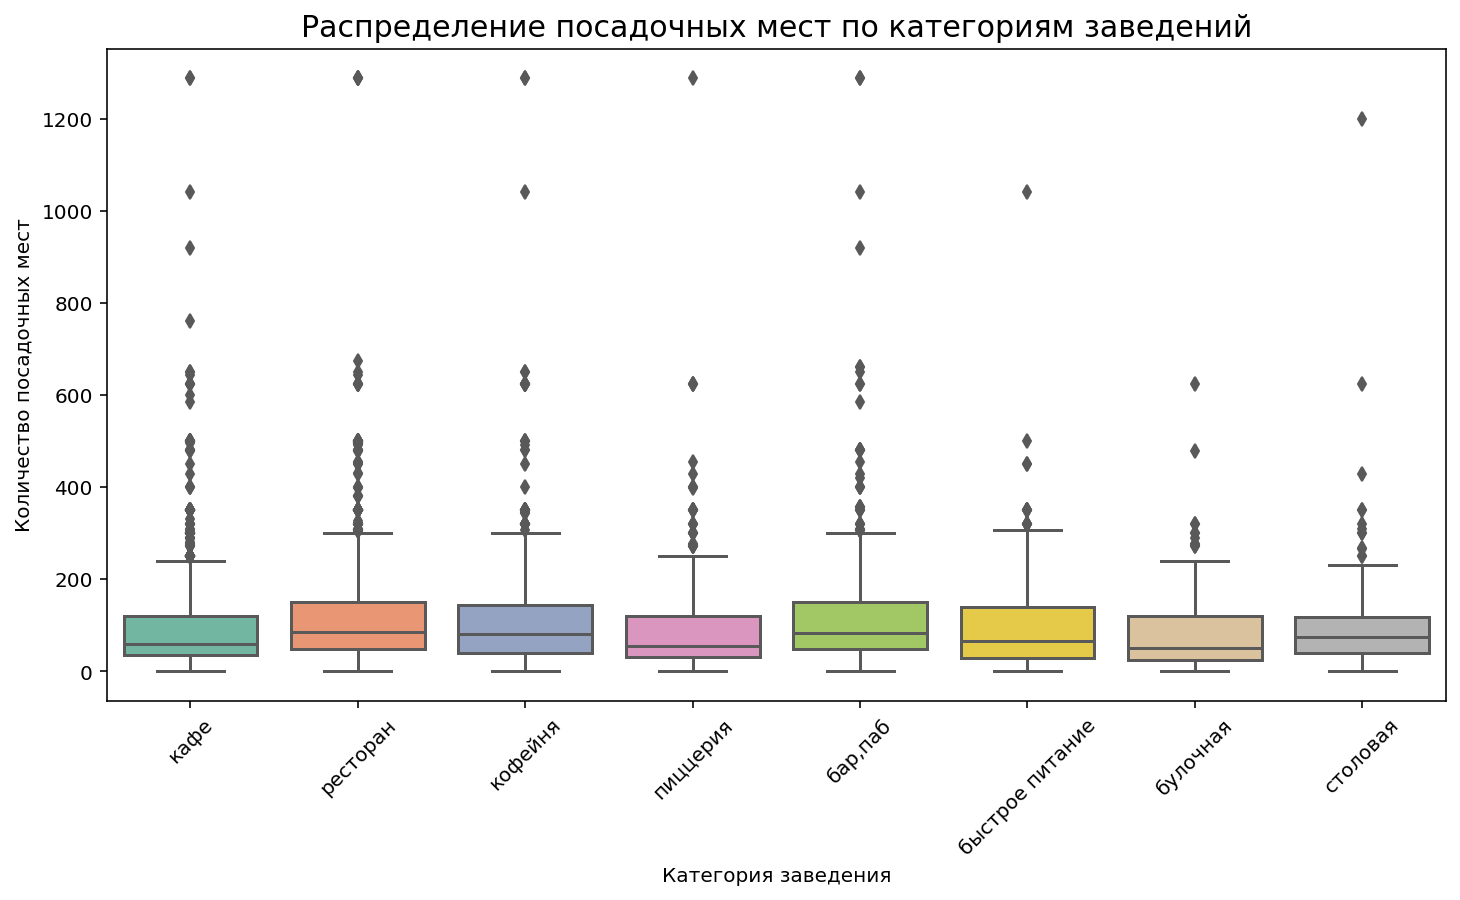

In [12]:
plt.figure(figsize=(12,6))

ax = sns.boxplot(x='category', y='seats', data=data, palette="Set2")
ax.set_xlabel('Категория заведения')
ax.set_ylabel('Количество посадочных мест')
ax.set_title('Распределение посадочных мест по категориям заведений', fontsize = 15)
plt.xticks(rotation=45)
plt.show()

В распределении заметны явные выбросы, превышеющие 1000 и даже 1200 посадочных мест практически в каждой категории. Возможно это Фуд-спейсы, которые делят общее помещение. Выведем таблицу самых крупных заведений

In [13]:
data[
    ["name", "address","category", "district", "seats", "street", "chain"]
].query('seats >= 1000').sort_values(by='address', ascending=False)

name                                     address  \
6574              мюнгер   москва, проспект вернадского, 97, корп. 1   
6658              гудбар   москва, проспект вернадского, 97, корп. 1   
6518         delonixcafe   москва, проспект вернадского, 94, корп. 1   
6641    one price coffee    москва, проспект вернадского, 84, стр. 1   
6771               точка    москва, проспект вернадского, 84, стр. 1   
6807  loft-cafe академия    москва, проспект вернадского, 84, стр. 1   
6808        яндекс лавка    москва, проспект вернадского, 51, стр. 1   
6838  alternative coffee    москва, проспект вернадского, 41, стр. 1   
6524           ян примус  москва, проспект вернадского, 121, корп. 1   
6684     пивной ресторан  москва, проспект вернадского, 121, корп. 1   
6690      японская кухня  москва, проспект вернадского, 121, корп. 1   
4231  рестобар argomento    москва, кутузовский проспект, 41, стр. 1   
2713         ваня и гоги     москва, измайловское шоссе, 71, корп. а   
2722           маргарита     москва, измайловское шоссе, 71, корп. а   
2770         шоколадница     москва, измайловское шоссе, 71, корп. а   
2966            матрешка     москва, измайловское шоссе, 71, корп. а   

             category                          district   seats  \
6574         пиццерия   Западный административный округ  1288.0   
6658          бар,паб   Западный административный округ  1288.0   
6518         ресторан   Западный административный округ  1288.0   
6641          кофейня   Западный административный округ  1288.0   
6771             кафе   Западный административный округ  1288.0   
6807             кафе   Западный административный округ  1288.0   
6808         ресторан   Западный административный округ  1288.0   
6838          кофейня   Западный административный округ  1288.0   
6524         ресторан   Западный административный округ  1288.0   
6684          бар,паб   Западный административный округ  1288.0   
6690         ресторан   Западный административный округ  1288.0   
4231         столовая   Западный административный округ  1200.0   
2713          бар,паб  Восточный административный округ  1040.0   
2722  быстрое питание  Восточный административный округ  1040.0   
2770          кофейня  Восточный административный округ  1040.0   
2966             кафе  Восточный административный округ  1040.0   

                     street  chain  
6574   проспект вернадского      1  
6658   проспект вернадского      0  
6518   проспект вернадского      0  
6641   проспект вернадского      1  
6771   проспект вернадского      1  
6807   проспект вернадского      0  
6808   проспект вернадского      1  
6838   проспект вернадского      0  
6524   проспект вернадского      1  
6684   проспект вернадского      0  
6690   проспект вернадского      1  
4231   кутузовский проспект      0  
2713     измайловское шоссе      0  
2722     измайловское шоссе      1  
2770     измайловское шоссе      1  
2966     измайловское шоссе      0

Некоторые заведения действительно находятся на одном и том же адресе, но 11 заведений объединяет количество мест и улица расположения, при том, что номер дома отличается. Скорее всего данные были ложно объеденены. Ограничим аномалии до 600 посадочных мест и детальней посмотрим разбивку по категориям 

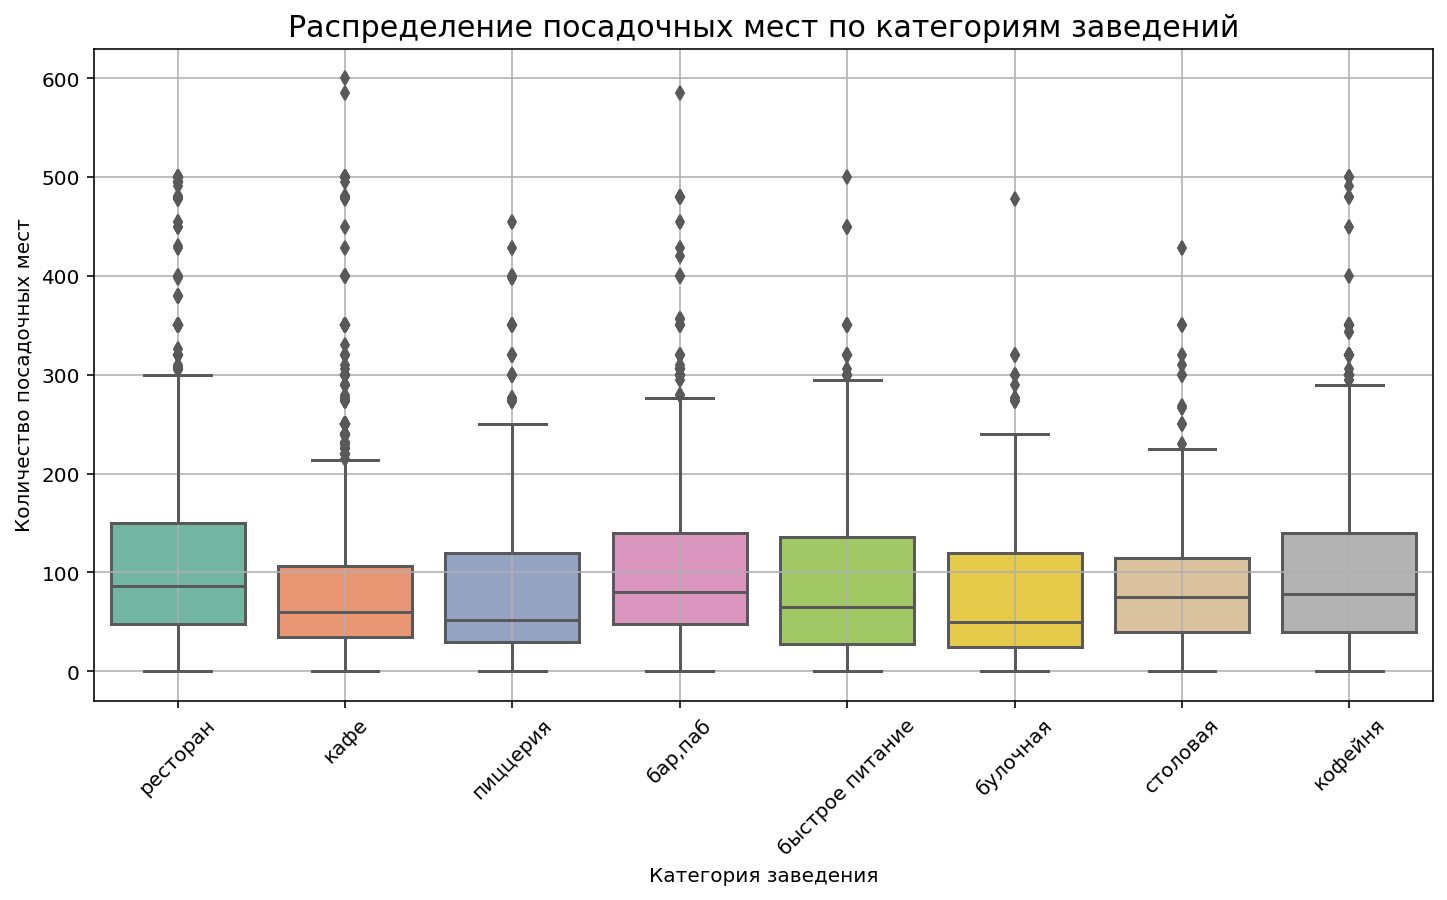

In [14]:
clean_data = data.query('seats <= 600')

plt.figure(figsize=(12,6))

ax = sns.boxplot(x='category', y='seats', data=clean_data, palette="Set2")
ax.set_xlabel('Категория заведения')
ax.set_ylabel('Количество посадочных мест')
ax.set_title('Распределение посадочных мест по категориям заведений', fontsize = 15)
plt.xticks(rotation=45)
plt.grid()
plt.show()

В разрезе наибольшее количество посадочных мест в ресторанах, барах, заведениях быстрого питания и кофейнях. В среднем заведения не превышают 100 посадочных мест 

### Сетевые заведения  <a class="anchor" id="chain"></a>

In [15]:
is_chain = data.groupby('chain', as_index=False)['rating'].count()
is_chain = is_chain.rename(columns={'rating':'total'})

In [16]:
fig = go.Figure(data=[go.Pie(labels=is_chain['chain'], values=is_chain['total'])])

fig.update_layout(title='Доля сетевых заведений')

fig.show()


Среди заведений Москвы 38,1% рынка принадлежит сетевым заведениям и 61,9% индивидуальным рестораторам (3205 против 5201). Посмотрим какие категории чаще всего и реже всего открываются под сетевыми брендами

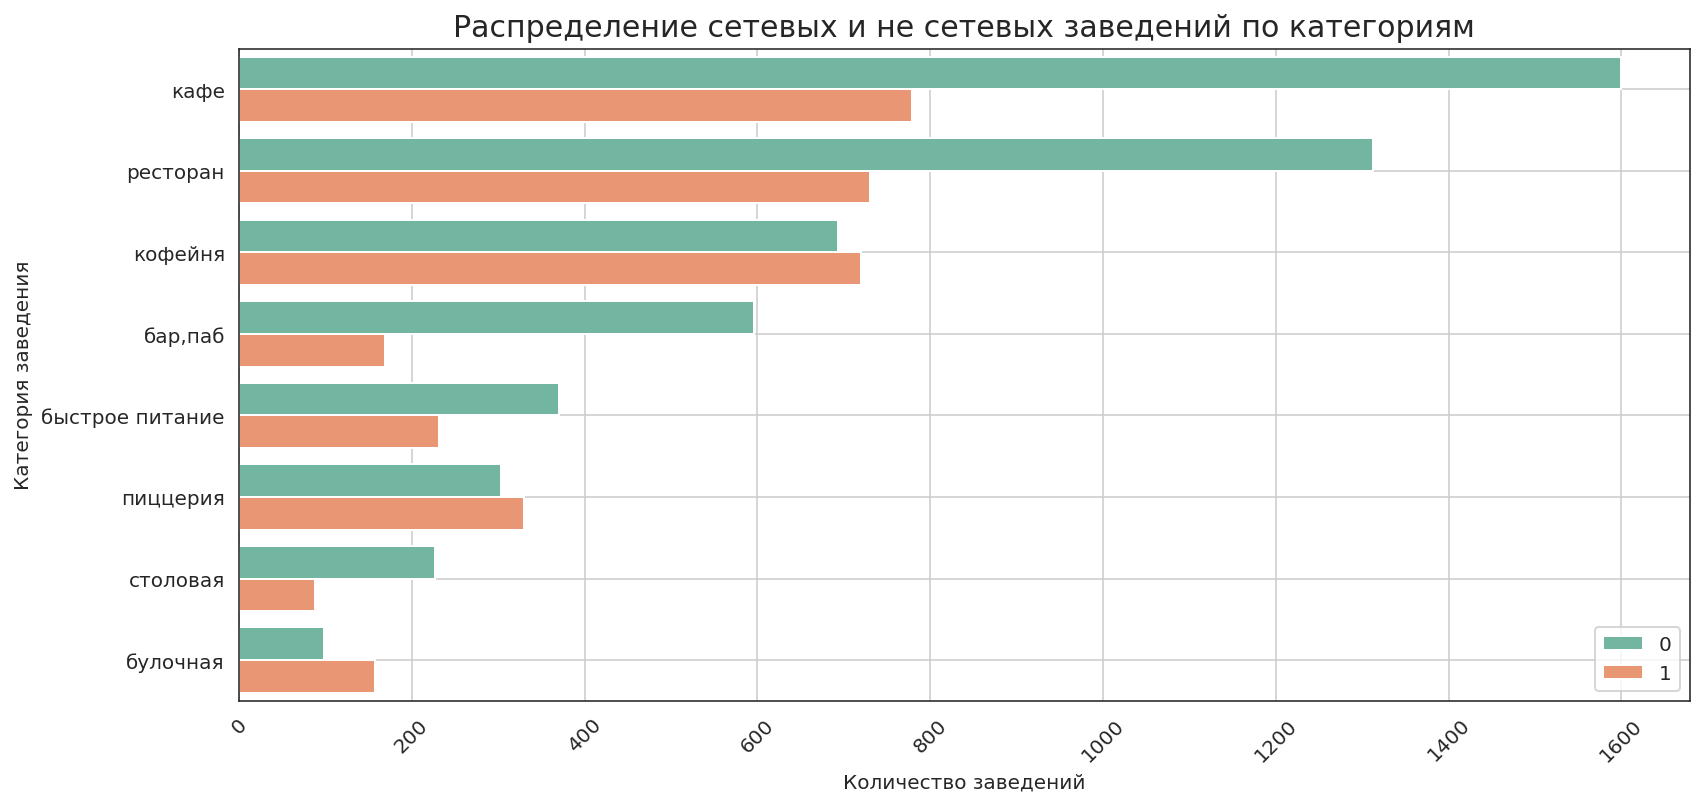

In [17]:
data_ed = data.groupby(['category', 'chain'], \
                        as_index = False)[['rating']].count().sort_values(by='rating', ascending=False)

sns.set_style('white')
plt.figure(figsize=(13, 6))

# строим столбчатый график средствами seaborn
sns.barplot(x='rating', y='category', data=data_ed, hue='chain', palette="Set2")
# формируем заголовок графика и подписи осей средствами matplotlib
plt.title('Распределение сетевых и не сетевых заведений по категориям', fontsize = 15)
plt.xlabel('Количество заведений')
plt.ylabel('Категория заведения')
# поворачиваем подписи значений по оси X на 45 градусов
plt.xticks(rotation=45)
# выбираем положение легенды и указываем размер шрифта
plt.legend(loc='lower right', fontsize=10)
# добавляем сетку
plt.grid()
# отображаем график на экране
plt.show()

Выводы по графику распределения:
* Кафе и рестораны не так часто открываются под "флагом" бренда, но по сравнению с другими категориями количество сетевых заведений достаточно большое
* Кафейни, пиццерии и булочные чаще открывают сетевики
* Доля сетевых баров в три раза ниже чем аутентичных заведений
* Несмотря на известность многих сетевых брендов быстрого питания заведений вне сети все таки больше
 
Посмотрим на топ-15 сетевиков, которые открыли больше всего заведений

In [18]:
chain_rest = data[
    ["name", "address","category", "district", "seats", "street", "chain"]
].query('chain == 1').sort_values(by='name', ascending=True)

chain_rest = chain_rest.groupby(['name', 'category'], \
                        as_index = False)[['chain']].count().sort_values(by='chain', ascending=False).head(15)

In [66]:
fig = px.bar(chain_rest, y='chain', x='name', text='chain', color='name')
# оформляем график
fig.update_layout(title='Топ-15 сетевых общепитов, по количеству заведений',
                   xaxis_title='Название сети',
                   yaxis_title='Количество заведений')
fig.show() # выводим график

Среди 15 самых крупных сетевых брендов:
* Шоколадница самый крупный сетевой бренд с  119 заведениями
* В тройку попали две пиццерии: Доминосс Пицца (76 заведений) и Додо пицца (74 заведения)
* Среди крупнейших общепитов в топ попала одна булочная - Буханка (25 заведений)
 
Следуя перечню заведений, попавших в топ, определяется закономерность в классификации, наиболее встречающихся сетевых брендов. Посмотрим какую долю они занимают в категории топ-15.

In [20]:
fig = go.Figure(data=[go.Pie(labels=chain_rest['category'], values=chain_rest['chain'], hole=.8)])

fig.update_layout(
    annotations=[dict(text='Доля топ-15 <br> сетевых заведений <br> по категориям', x=0.5, y=0.5, font_size=20, showarrow=False)])
fig.show()

Среди 15 самых крупных сетевых брендов попали 5 категорий. Из них:
* Долю в 45,6% занимают кофейни
* Примерно одинаковая доля досталась ресторанам и пиццериям (20,1% и 19,5%)
* Замыкают пятерку Кафе (11,6%) и булочные (3,26%)


### Территориальное распределение  <a class="anchor" id="map"></a>

Какие административные районы Москвы присутствуют в датасете? Отобразите общее количество заведений и количество заведений каждой категории по районам. Попробуйте проиллюстрировать эту информацию одним графиком.

In [21]:
dist_rest = data[
    ["category", "district","rating"]
].sort_values(by='district', ascending=True)

total_per_region = dist_rest.groupby(['district'], \
                        as_index = False)[['rating']].count().sort_values(by='rating', ascending=False)

dist_count = dist_rest.groupby(['district', 'category'], \
                        as_index = False)[['rating']].count().sort_values(by='rating', ascending=False)

In [69]:
# строим столбчатую диаграмму 
fig = px.bar(total_per_region.sort_values(by='rating', ascending=True), # загружаем данные и заново их сортируем
             x='rating', # указываем столбец с данными для оси X
             y='district', # указываем столбец с данными для оси Y
             text='rating'
                                       
            )
# оформляем график
fig.update_layout(title='Количество заведений общепта в округах Москвы',
                   xaxis_title='Количество заведений',
                   yaxis_title='Округ')
fig.show() # выводим график

* Наибольшее количество заведений находится в ЦАО. Там открыто более чем в два раза больше точек общепита
* В среднем по районом москвы открыто от 700 до 900 заведений 
* Наименее превликательным для рестораторов стал Северо-западный административный округ. Там открыто всего 409 заведения

Посмотрим категории заведения по округам

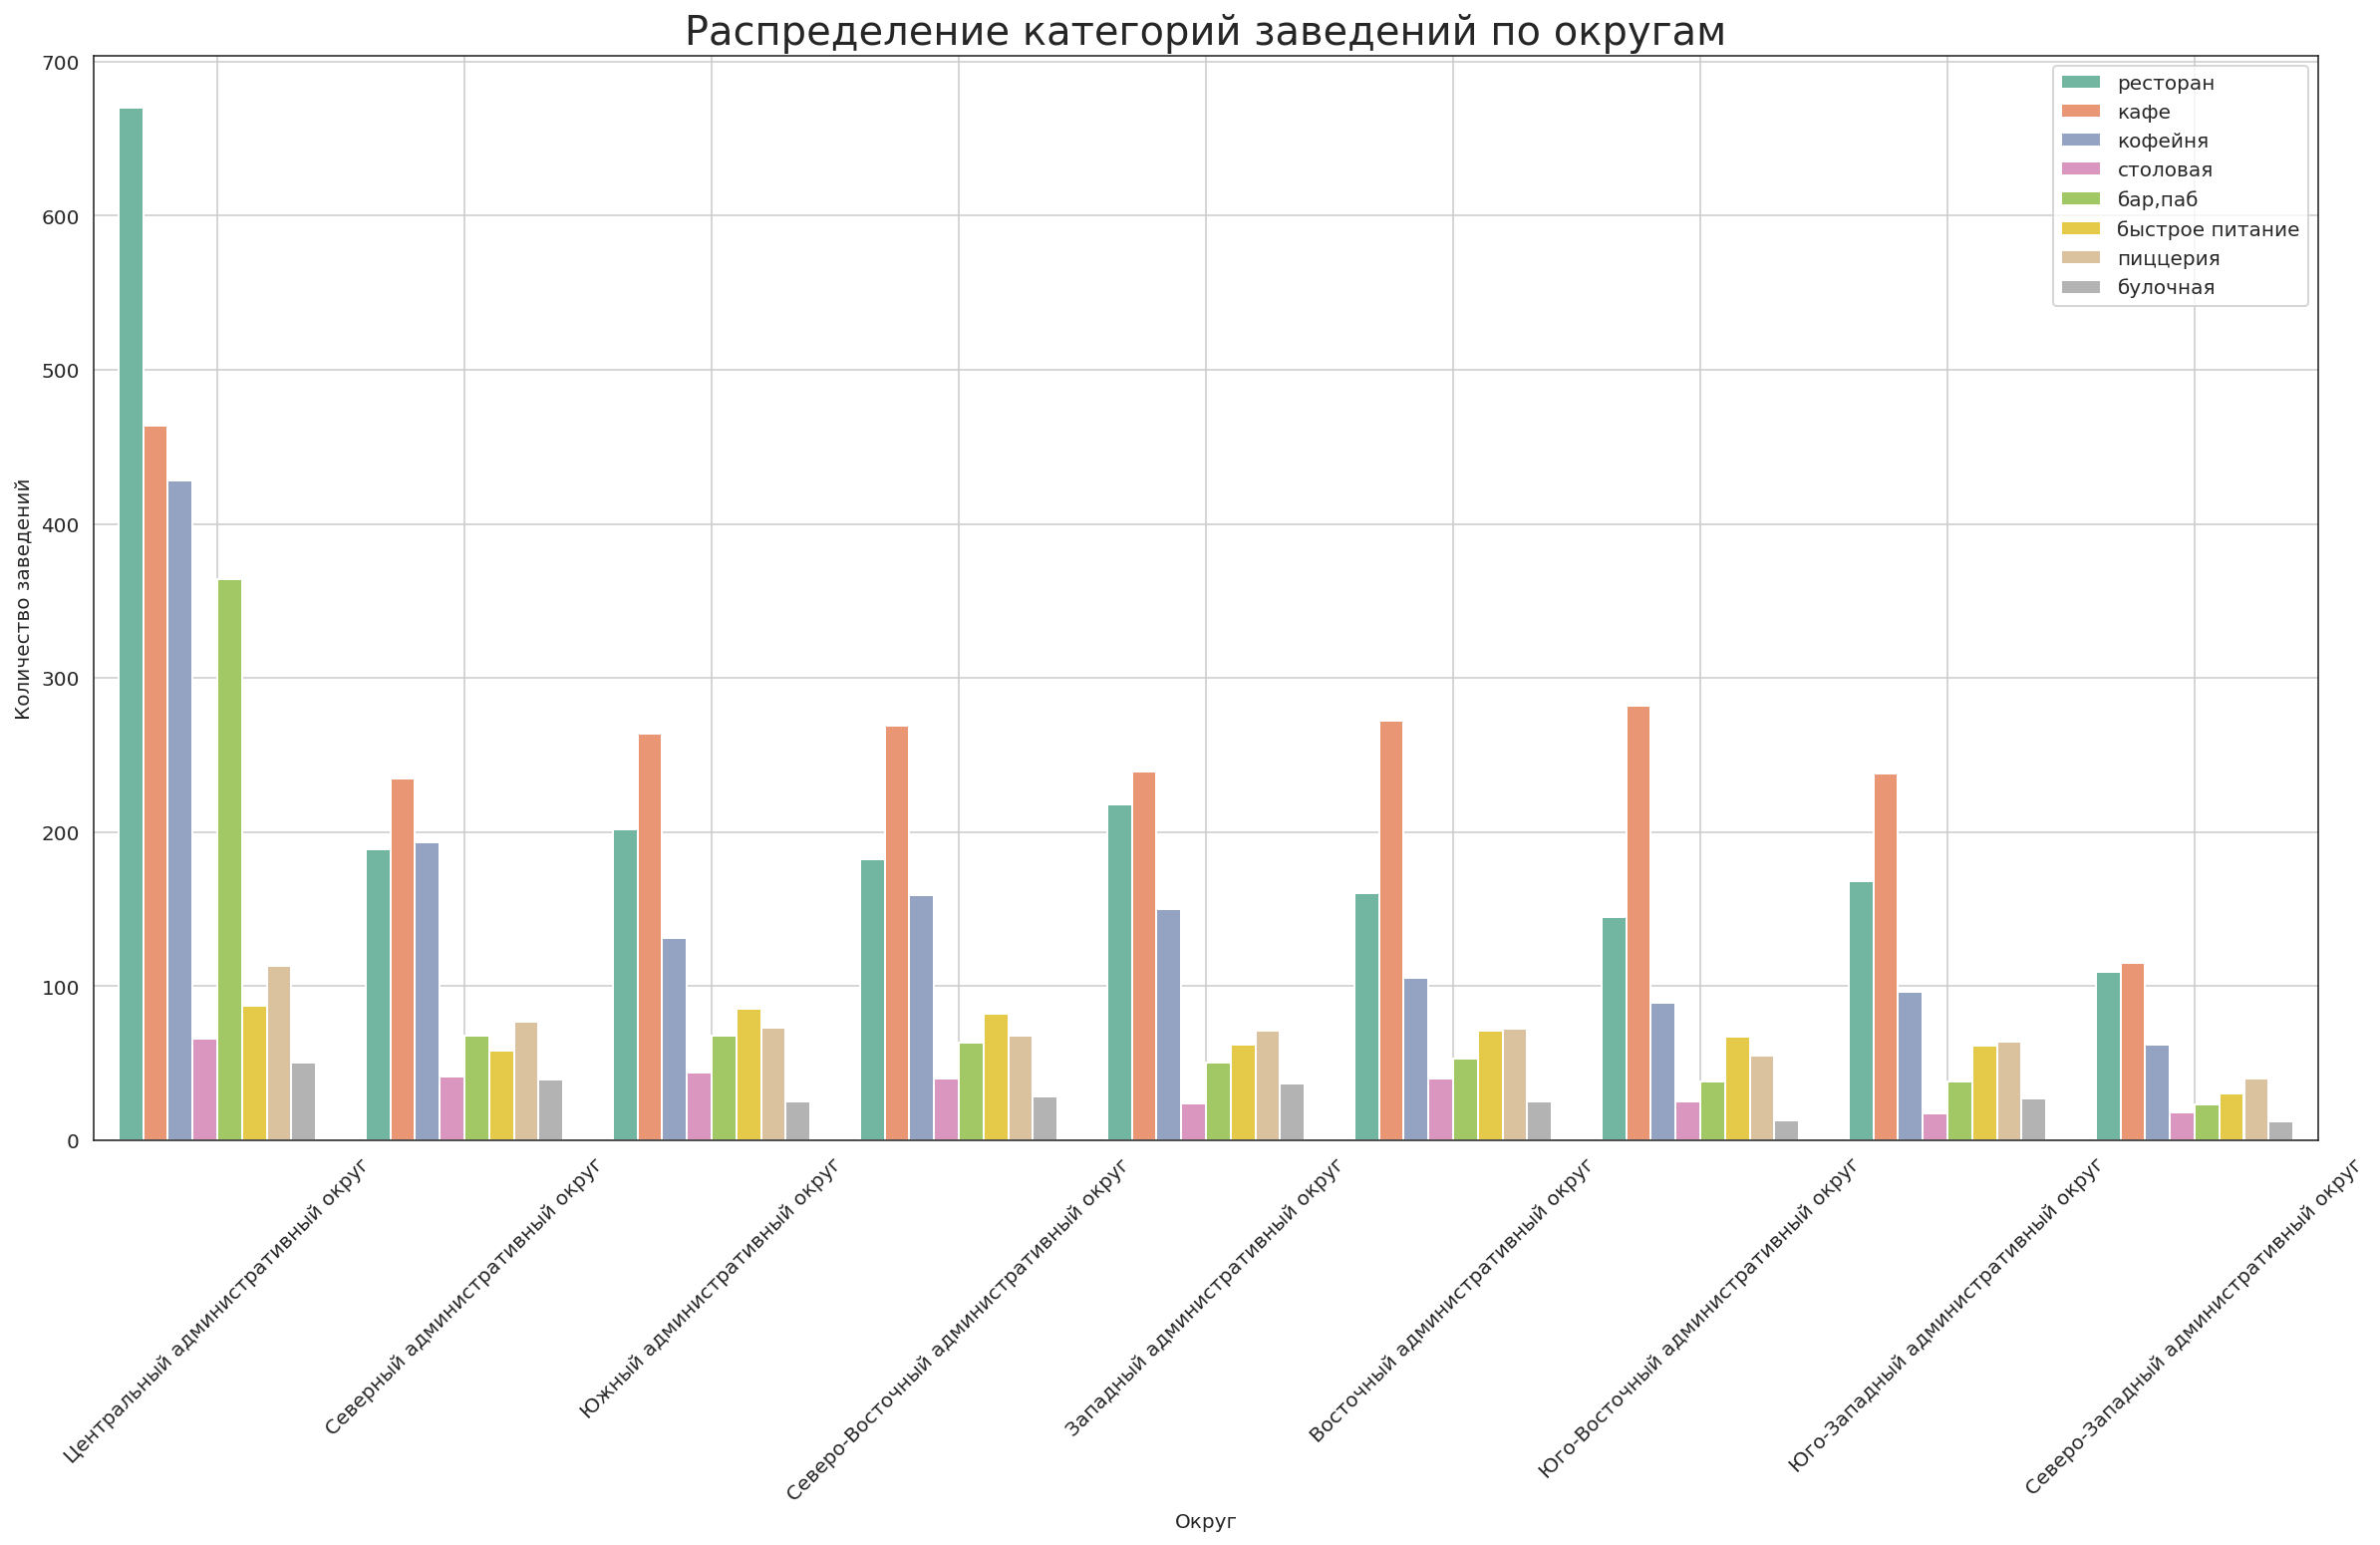

In [136]:
plt.figure(figsize=(20, 10))
sns.countplot(x='district', hue='category', data=dist_rest, order=dist_rest['district'].value_counts().index, palette="Set2")
plt.title('Распределение категорий заведений по округам', fontsize = 20)
plt.xlabel('Округ')
plt.ylabel('Количество заведений')
plt.xticks(rotation=45)
# выбираем положение легенды и указываем размер шрифта
plt.legend(loc='upper right', fontsize=10)
# добавляем сетку
plt.grid()
# отображаем график на экране
plt.show()

* Во всех районах, кроме ЦАО, лидируют кафе. Распределение заведений по категориям так же практически везде одинаковое
* В ЦАО на первом месте по категориям находятся рестораны. Так же в этом округе, в отличие от остальных, наибольшее количество баров

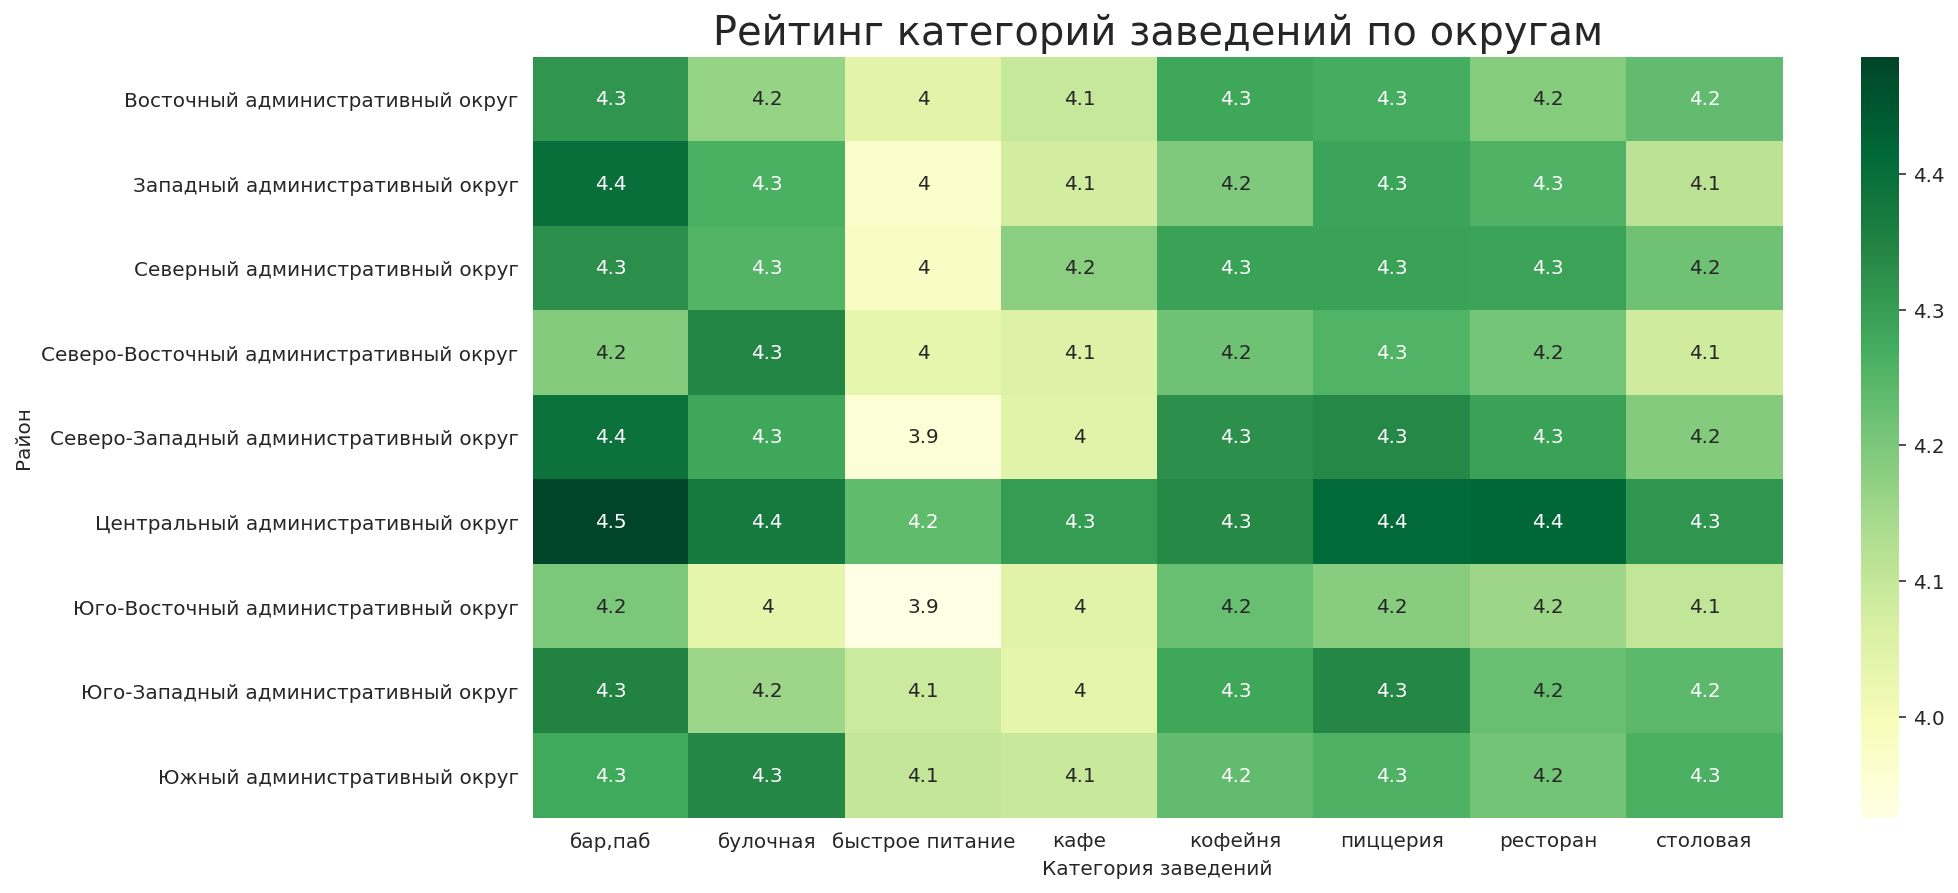

In [137]:
heat_data = data.pivot_table(index='district', columns='category', values='rating', aggfunc='mean')
plt.figure(figsize=(14,7))
plt.title('Рейтинг категорий заведений по округам', fontsize = 20)
ax = sns.heatmap(heat_data, annot=True, cmap="YlGn")
ax.set(xlabel="Категория заведений", ylabel="Район")
plt.show()

Рейтинг заведений по категориям колеблется от 3,9 до 4,5. Сильных разрывов по оценкам внутри категорий не наблюдается. согласно хитмепу, в среднем по районам:

* Выше всего оцененены бары и пабы в ЦАО (4,5)
* Минимальную оценку получили заведения быстрого питания в Северо-западном и Юго-восточном административных округах  (3,9)

Посмотрим обобщенные рейтинги на карте Москвы 

In [25]:
rating_df = data.groupby('district', as_index=False)['rating'].agg('median')

In [26]:
state_geo = '/datasets/admin_level_geomap.geojson'
# moscow_lat - широта центра Москвы, moscow_lng - долгота центра Москвы
moscow_lat, moscow_lng = 55.751244, 37.618423

# создаём карту Москвы
m = Map(location=[moscow_lat, moscow_lng], zoom_start=10)

Choropleth(
    geo_data=state_geo,
    data=rating_df,
    columns=['district', 'rating'],
    key_on='feature.name',
    fill_color='YlGn',
    fill_opacity=0.8,
    legend_name='Медианный рейтинг заведений по районам',
).add_to(m)

# выводим карту
m

Самые высокие рейтинги в центре Москвы. В остальные районах медианный рейтинг заведений распределен равномерно, за исключением  Северо-западного и Юго-восточного округа, где медианный показатель ниже всего. 

Ознакомимся с 15 улицами с самым большим количеством заведений

In [27]:
top_street = data.groupby(['street'], as_index = False)[['rating']].count().sort_values(by='rating', ascending=False).head(15)

In [61]:
fig = px.bar(top_street, y='rating', x='street', text='rating')
# оформляем график
fig.update_layout(title='Топ-15 улиц Москвы, по количеству заведений',
                   xaxis_title='Улица',
                   yaxis_title='Количество заведений')
fig.show() # выводим график

В целях исследования дополнительно посмотрим протяженность улицы, чтобы определить корелирует ли количество заведений с киллометражом на примере первых пяти улицах.

1. Больше всего заведений общепита расположились на проспекте Мира (8,9 км 184 заведения). 
2. ул. Профсоюзная (9,3 км 122 заведения). 
3. пр-т. Вернандского (8 км 108 заведения). 
4. Ленинский пр-т (14 км 107 заведения). 
5. Ленинградский пр-т (5,6 км 95 заведения). 

Проверим корреляцией Пирсона есть ли взаимосвязь 

In [29]:
d = {'km': [8.9, 9.3, 8, 14, 5.6], 'count': [184, 122, 108, 107, 95]}
df = pd.DataFrame(data=d)
df

print('Корреляция протяженности улицы и количества заведений составляет:',df['km'].corr(df['count'].apply(np.log)))

Корреляция протяженности улицы и количества заведений составляет: 0.09254831603307691


Корреляция крайне мала, нет оснований полагать что количество заведений общепита растет вместе с длинной улицы. Посмотрим какие заведения чаще всего встречаются на Топ-15 улицах

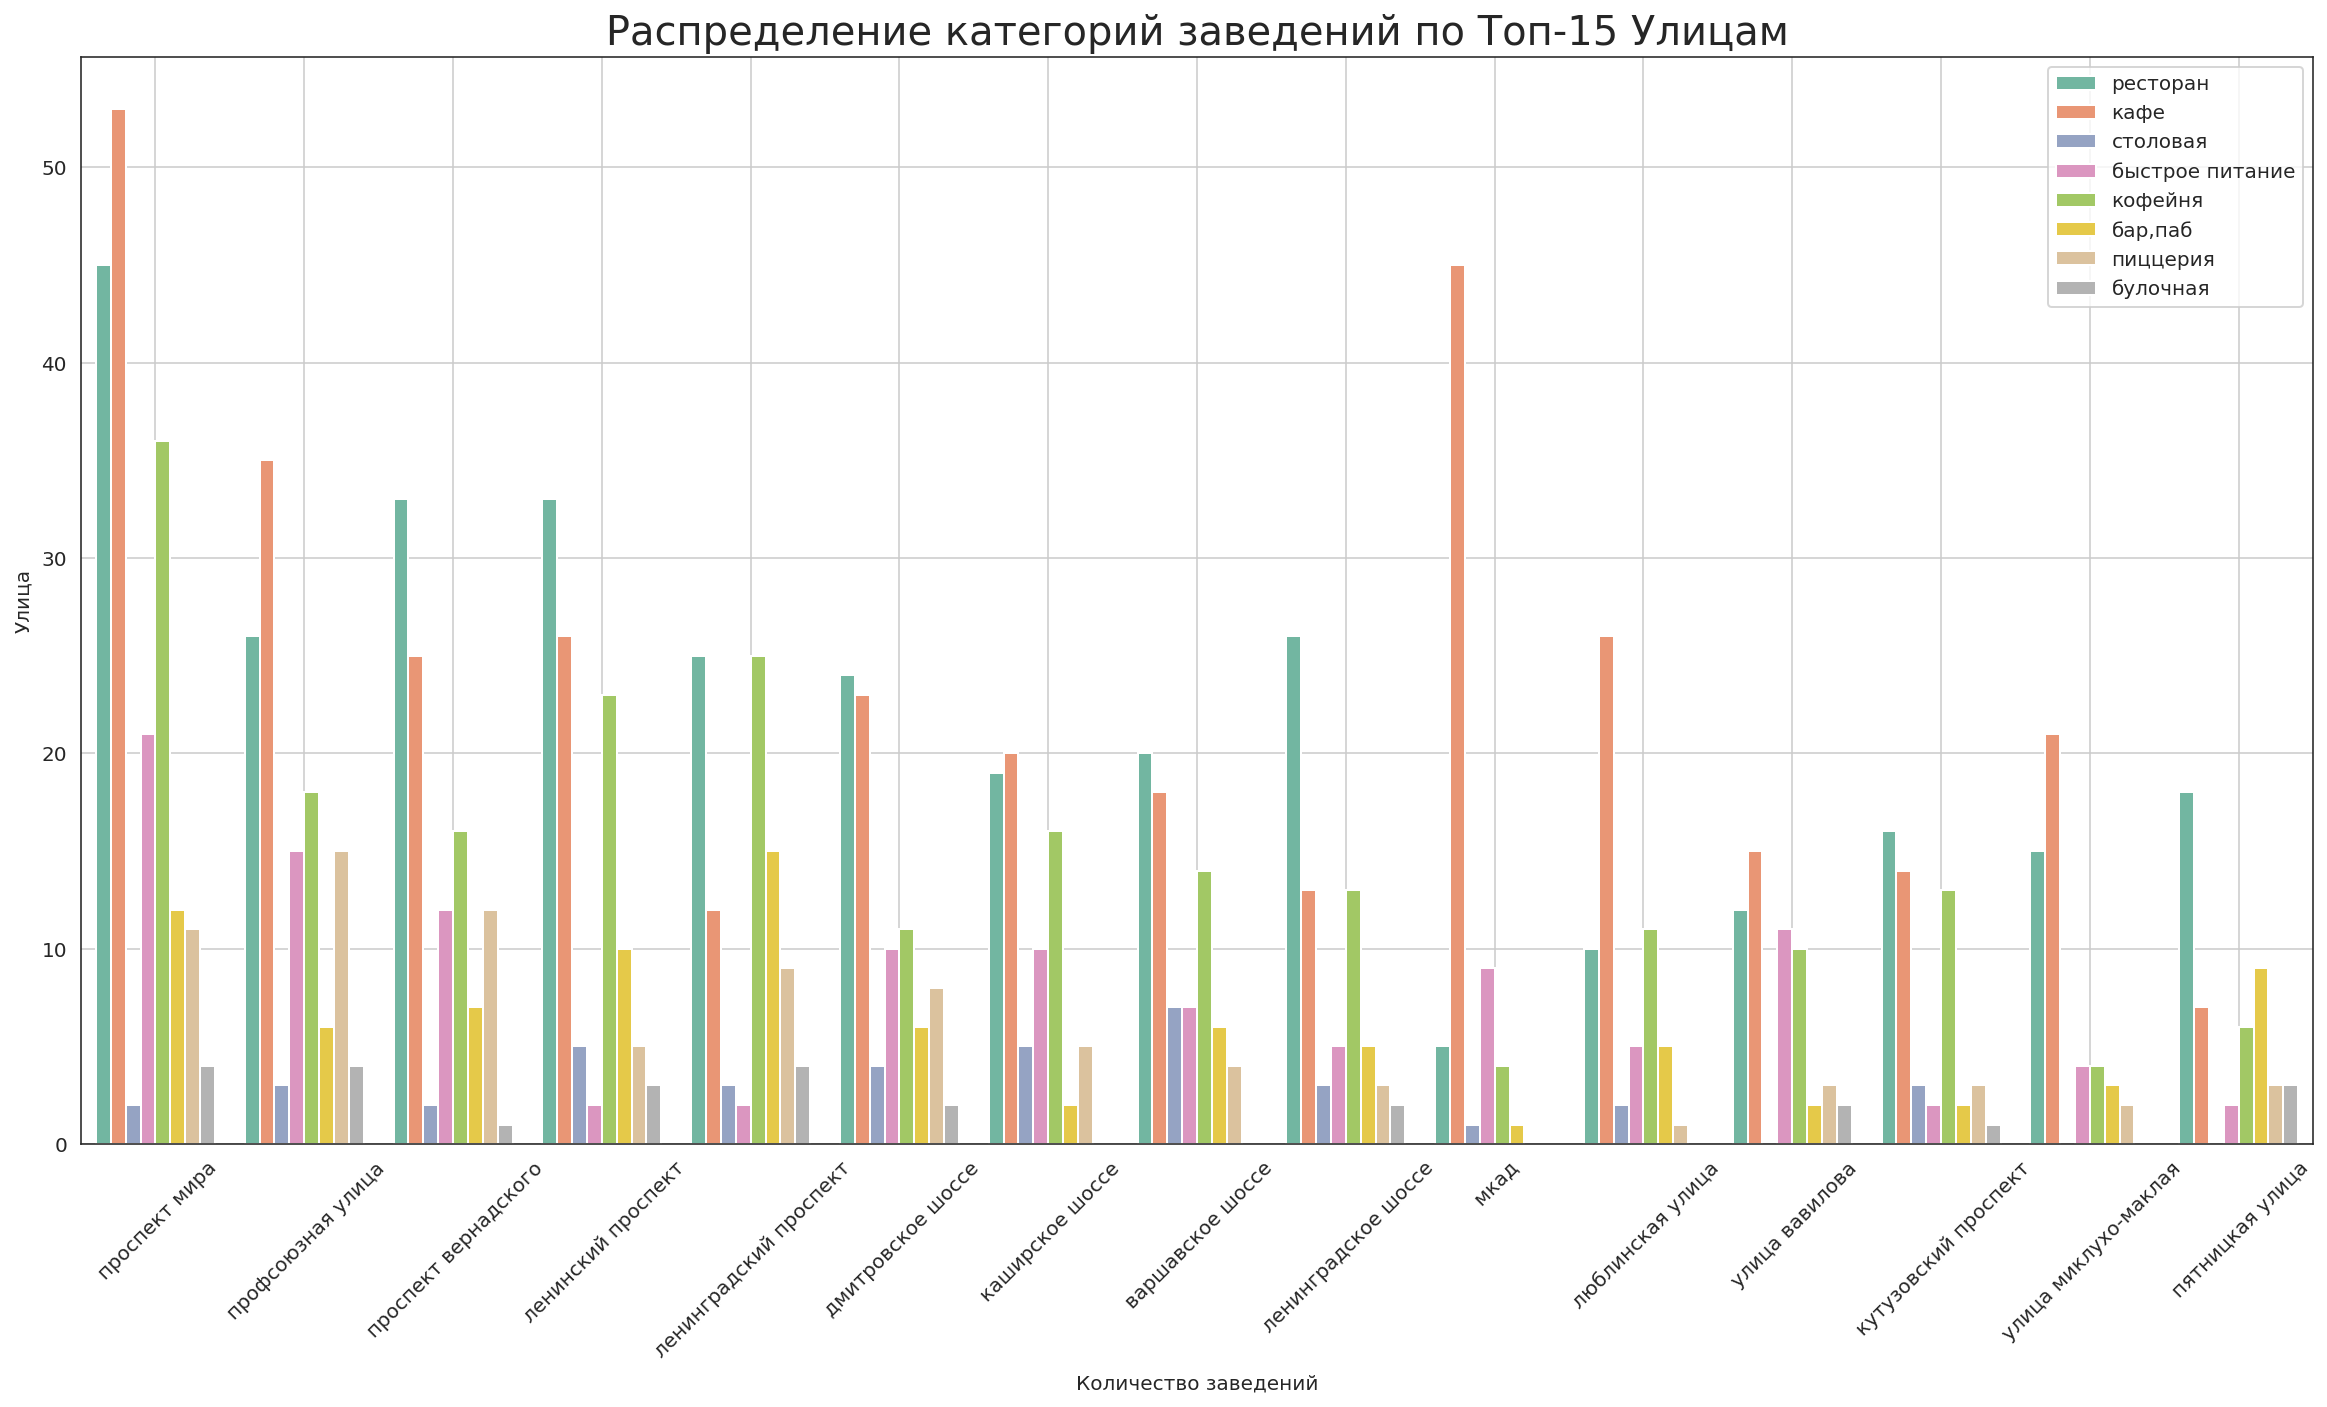

In [138]:
street_rest = data[
    ["category", "street","rating"]
].sort_values(by='street', ascending=True)

street_rest = street_rest.query('street in @top_street["street"]')

plt.figure(figsize=(20, 10))
sns.countplot(x='street', hue='category', data=street_rest, order=street_rest['street'].value_counts().index, palette="Set2")
plt.title('Распределение категорий заведений по Топ-15 Улицам', fontsize = 20)
plt.xlabel('Количество заведений')
plt.ylabel('Улица')
plt.xticks(rotation=45)
# выбираем положение легенды и указываем размер шрифта
plt.legend(loc='upper right', fontsize=10)
# добавляем сетку
plt.grid()
# отображаем график на экране
plt.show()

Из наблюдений:
* На самой оживленной улице, пр-те Мира, больше 50 кафе, 45 ресторанов и 35 кофеен. Это самые высокие показатели, в сравнению с другими улицами
* Значительное количество кофеен открыто на МКАДе(45). Остальных заведений не больше 10 штук.  
* Булочные отсутствуют на Варавском и Каширском шоссе, а так же на ул. Любленской и Миклухо-Маклая
* Пиццерий нет на МКАДе, ул. Пятницкая, ул. Вавилова, ул. Миклухо-Маклая

В противовес самым крупным улицам разберем самые маленькие, количество заведений общепита в которых не превышает 1й единицы

In [31]:
low_street = data.groupby(['street'], as_index = False)[['rating']].count().sort_values(by='rating', ascending=False)

low_street = low_street.query('rating == 1')

In [32]:
one_place_street = data[
    ["name", "address","category", "district", "seats", "street", "chain", "rating", "lat", "lng"]
]

one_place_street = one_place_street.query('street in @low_street["street"]')

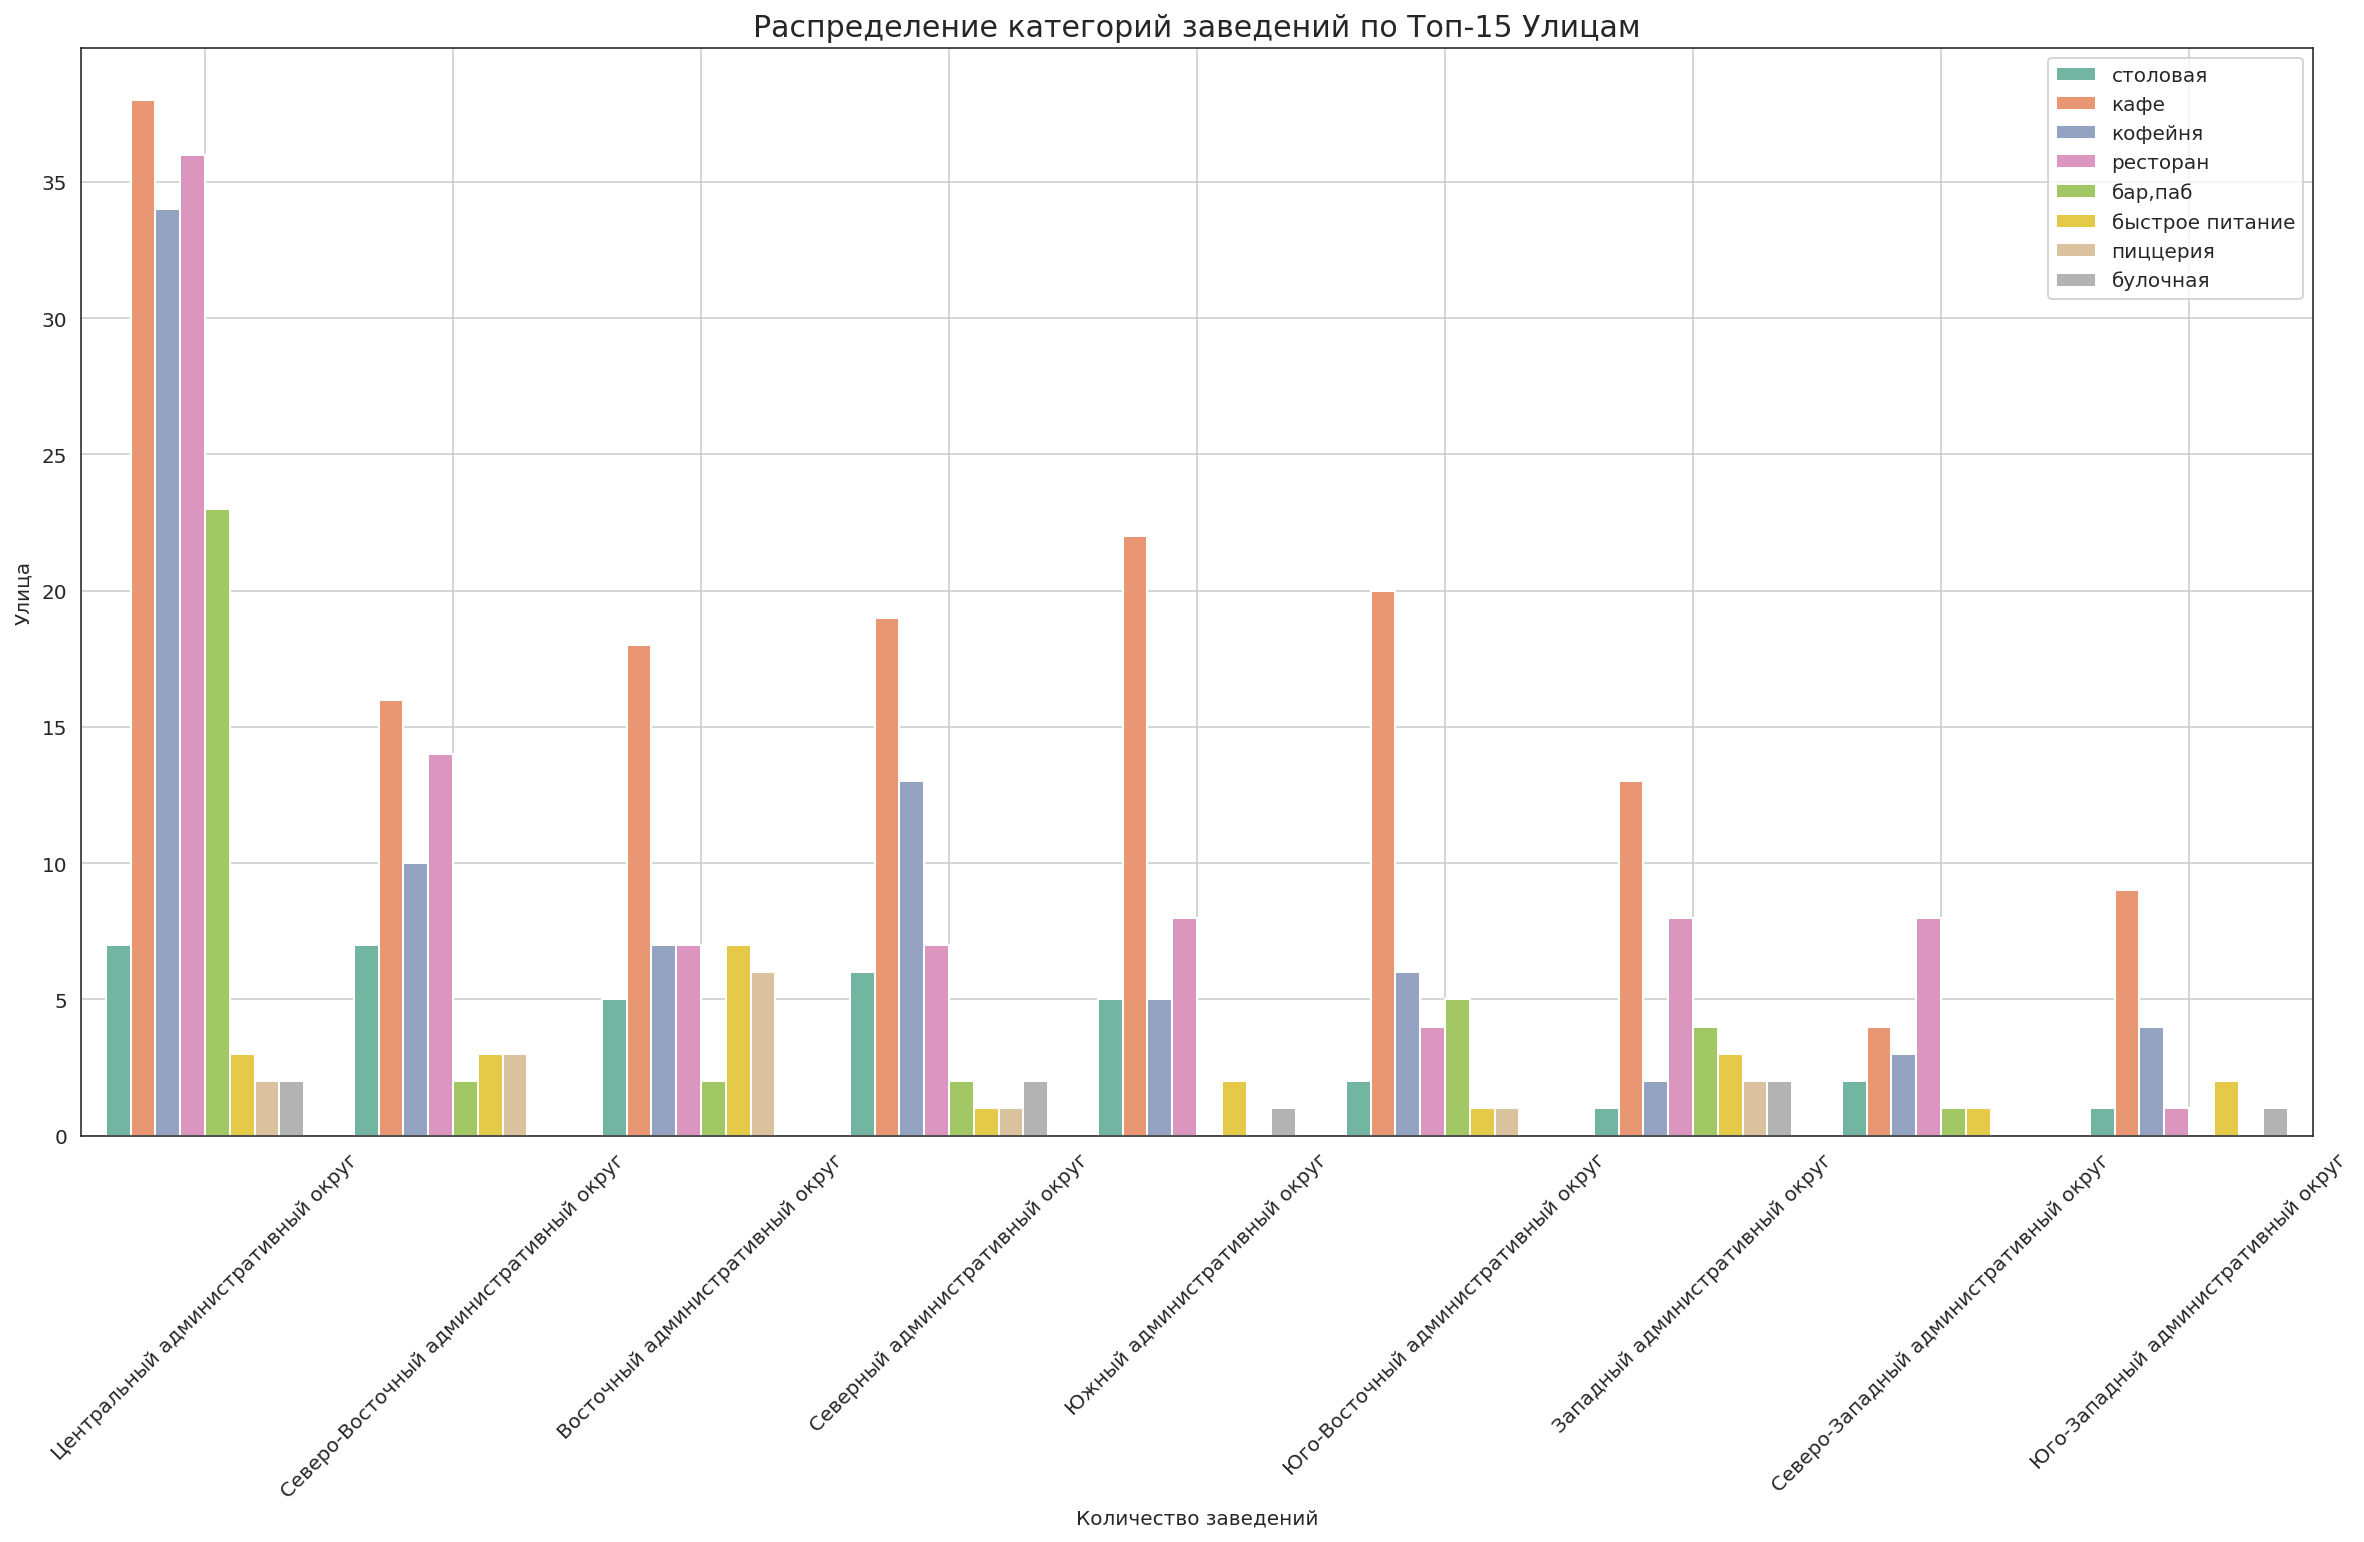

In [79]:
plt.figure(figsize=(20, 10))
sns.countplot(x='district', hue='category', data=one_place_street, 
              order=one_place_street['district'].value_counts().index, palette="Set2")
plt.title('Распределение категорий заведений по Топ-15 Улицам', fontsize = 15)
plt.xlabel('Количество заведений')
plt.ylabel('Улица')
plt.xticks(rotation=45)
# выбираем положение легенды и указываем размер шрифта
plt.legend(loc='upper right', fontsize=10)
# добавляем сетку
plt.grid()
# отображаем график на экране
plt.show()

* Больше всего "улиц-однушек" Расположены в ЦАО
* Среди всех административных округов выделяется категория с кафе
* Предполагаю, что в данном случае отсутствие большего количества заведений связано с размером улицы

Посмотрим пользуются ли популярностью такие заведения у сетевиков

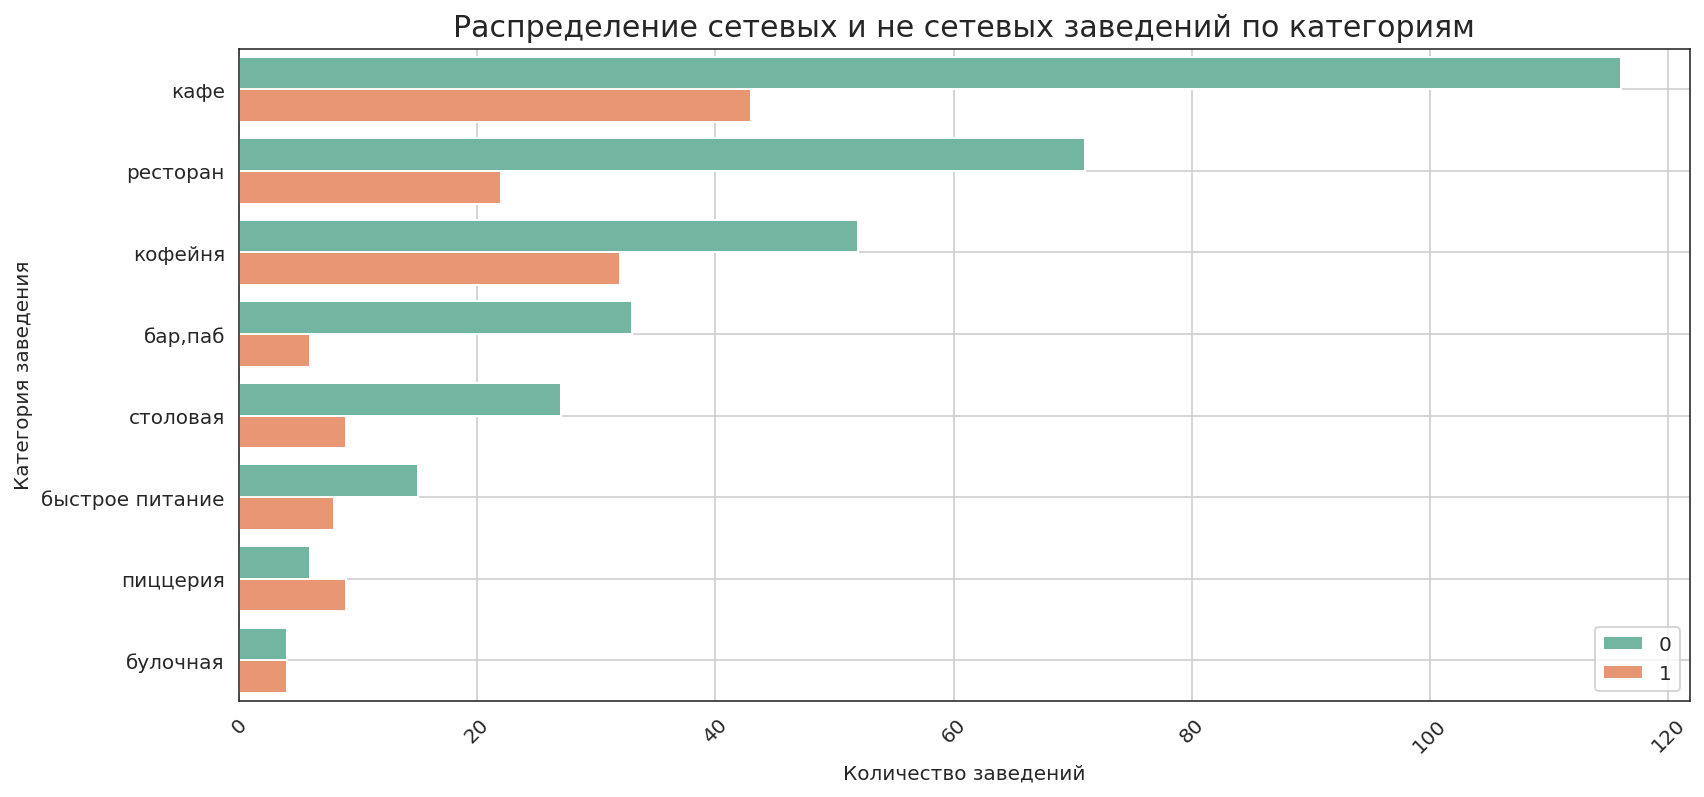

In [34]:
one_place_chain = one_place_street.groupby(['category', 'chain'], \
                        as_index = False)[['rating']].count().sort_values(by='rating', ascending=False)

sns.set_style('white')
plt.figure(figsize=(13, 6))

# строим столбчатый график средствами seaborn
sns.barplot(x='rating', y='category', data=one_place_chain, hue='chain', palette="Set2")
# формируем заголовок графика и подписи осей средствами matplotlib
plt.title('Распределение сетевых и не сетевых заведений по категориям', fontsize = 15)
plt.xlabel('Количество заведений')
plt.ylabel('Категория заведения')
# поворачиваем подписи значений по оси X на 45 градусов
plt.xticks(rotation=45)
# выбираем положение легенды и указываем размер шрифта
plt.legend(loc='lower right', fontsize=10)
# добавляем сетку
plt.grid()
# отображаем график на экране
plt.show()

В большинстве своем, за исключенем пиццерий, сетевые заведения обходят стороной маленькие улочки. Малый бизнес и локальные ресторатоы доминируют в этом срезе, в особенности в сегменте Кафе

In [35]:
rating_bill = data.groupby('district', as_index=False)['middle_avg_bill'].agg('median')
display(rating_bill.sort_values(by='middle_avg_bill', ascending=False))

m = Map(location=[moscow_lat, moscow_lng], zoom_start=10)

Choropleth(
    geo_data=state_geo,
    data=rating_bill,
    columns=['district', 'middle_avg_bill'],
    key_on='feature.name',
    fill_color='YlGn',
    fill_opacity=0.8,
    legend_name='Медианный рейтинг среднего чека по районам',
).add_to(m)

# выводим карту
m

district  middle_avg_bill
1          Западный административный округ           1000.0
5       Центральный административный округ           1000.0
4   Северо-Западный административный округ            700.0
2          Северный административный округ            650.0
7      Юго-Западный административный округ            600.0
0         Восточный административный округ            575.0
3  Северо-Восточный административный округ            500.0
8             Южный административный округ            500.0
6     Юго-Восточный административный округ            450.0

* Самые дорогие заведения расположены в центре Москвы и Западном административном округе
* Среди "золотой середины" среднего чека по Москве оказались в Северо-Западный административный округ и Северный административный округ
* Средний чек в остальных округах ниже среднего. Самый дешевый вариант "поесть" встречается в Юго-Восточном административном округе и Южном административном округе

Посмотрим значение средних чеков с разбивкой по категориям и округам

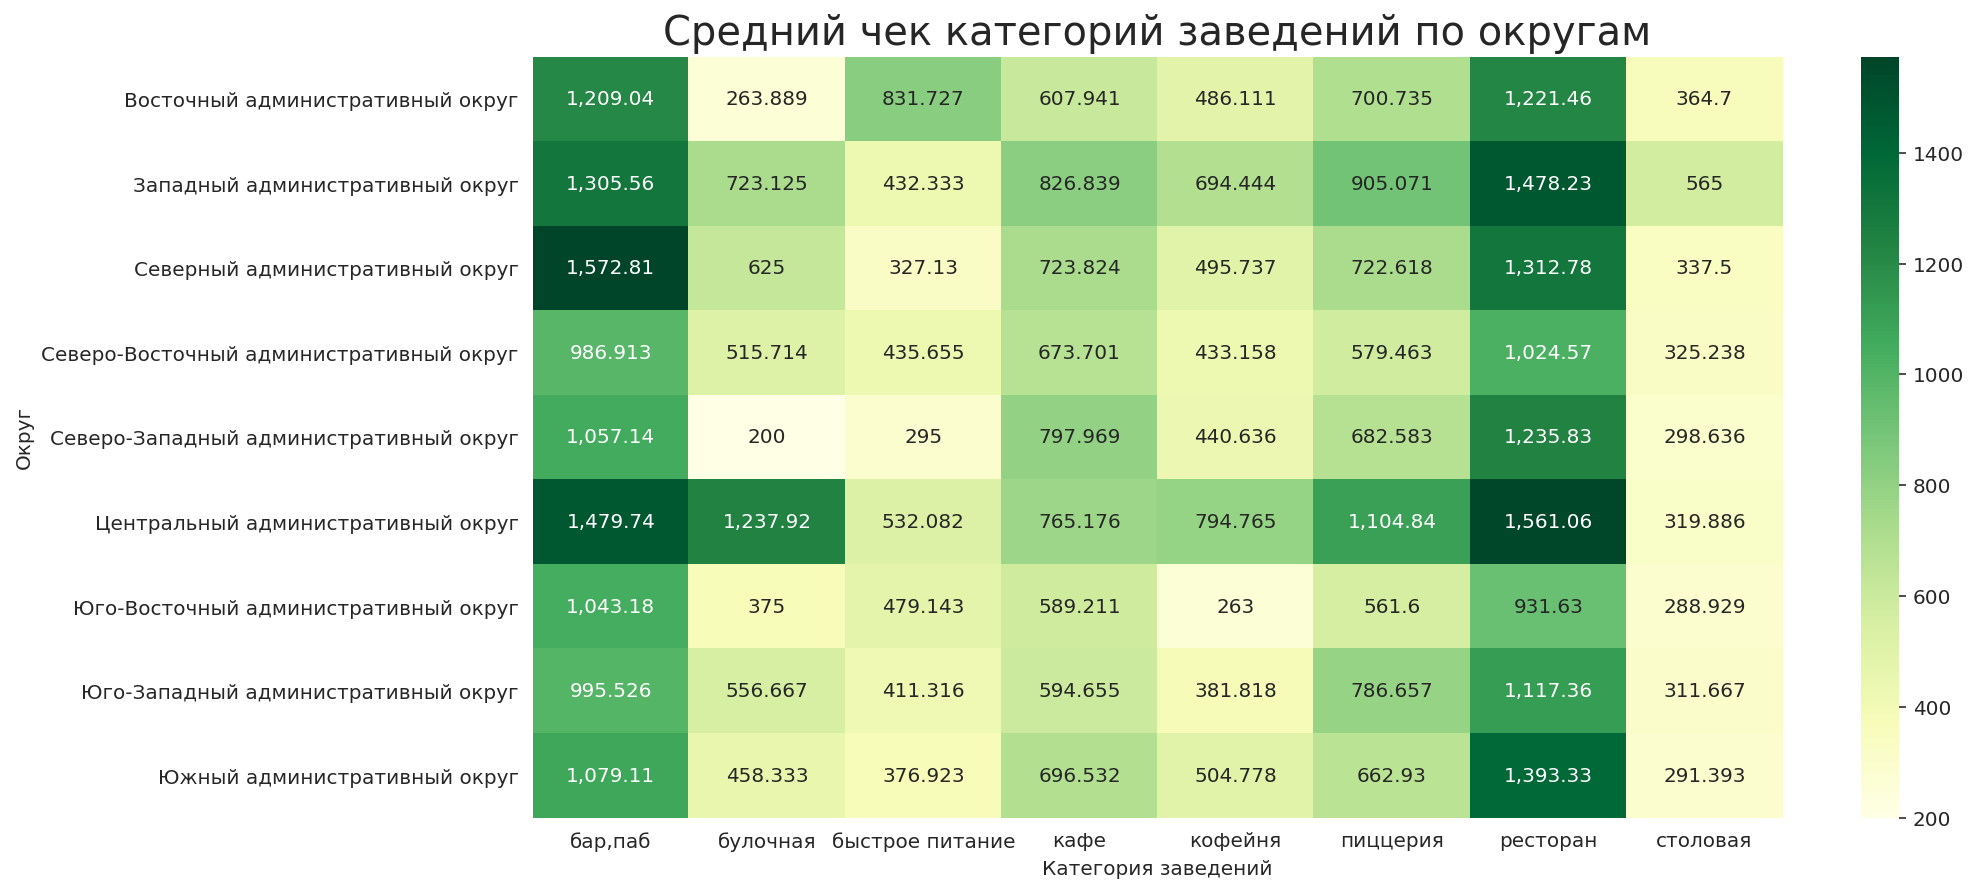

In [139]:
heat_data = data.pivot_table(index='district', columns='category', values='middle_avg_bill', aggfunc='mean')
plt.figure(figsize=(14,7))
plt.title('Средний чек категорий заведений по округам', fontsize = 20)
ax = sns.heatmap(heat_data, annot=True, cmap="YlGn", fmt=',g')
ax.set(xlabel="Категория заведений", ylabel="Округ")
plt.show()

* Наибольший разброс цен в категории булочная (от 200р в Северо-Западном округе до 1237,92 в ЦАО)
* Самый большой средний чек у Баров в САО (1572,81) и ресторанов в ЦАО  (1561,06)
* Самый низкий средний чек в категории булочная в Северо-Западном округе (200р)

### Дополнительный анализ  <a class="anchor" id="extra"></a>

In [116]:
print('Количество уникальных комбинаций графика работ:',data['hours'].nunique()) 

Количество уникальных комбинаций графика работ: 1307


Посмотрим распределение по трем временным категориям, работающих с 10 до 22, открывающиеся в 8 утра и закрывающиеся в 2 ночи

In [112]:
daytime = data.copy()

In [134]:
daytime['ten_to_ten'] = daytime['hours'].str.contains('10:00–22:00')
daytime['morning'] = daytime['hours'].str.contains('07:00-')
daytime['night'] = daytime['hours'].str.contains('02:00')


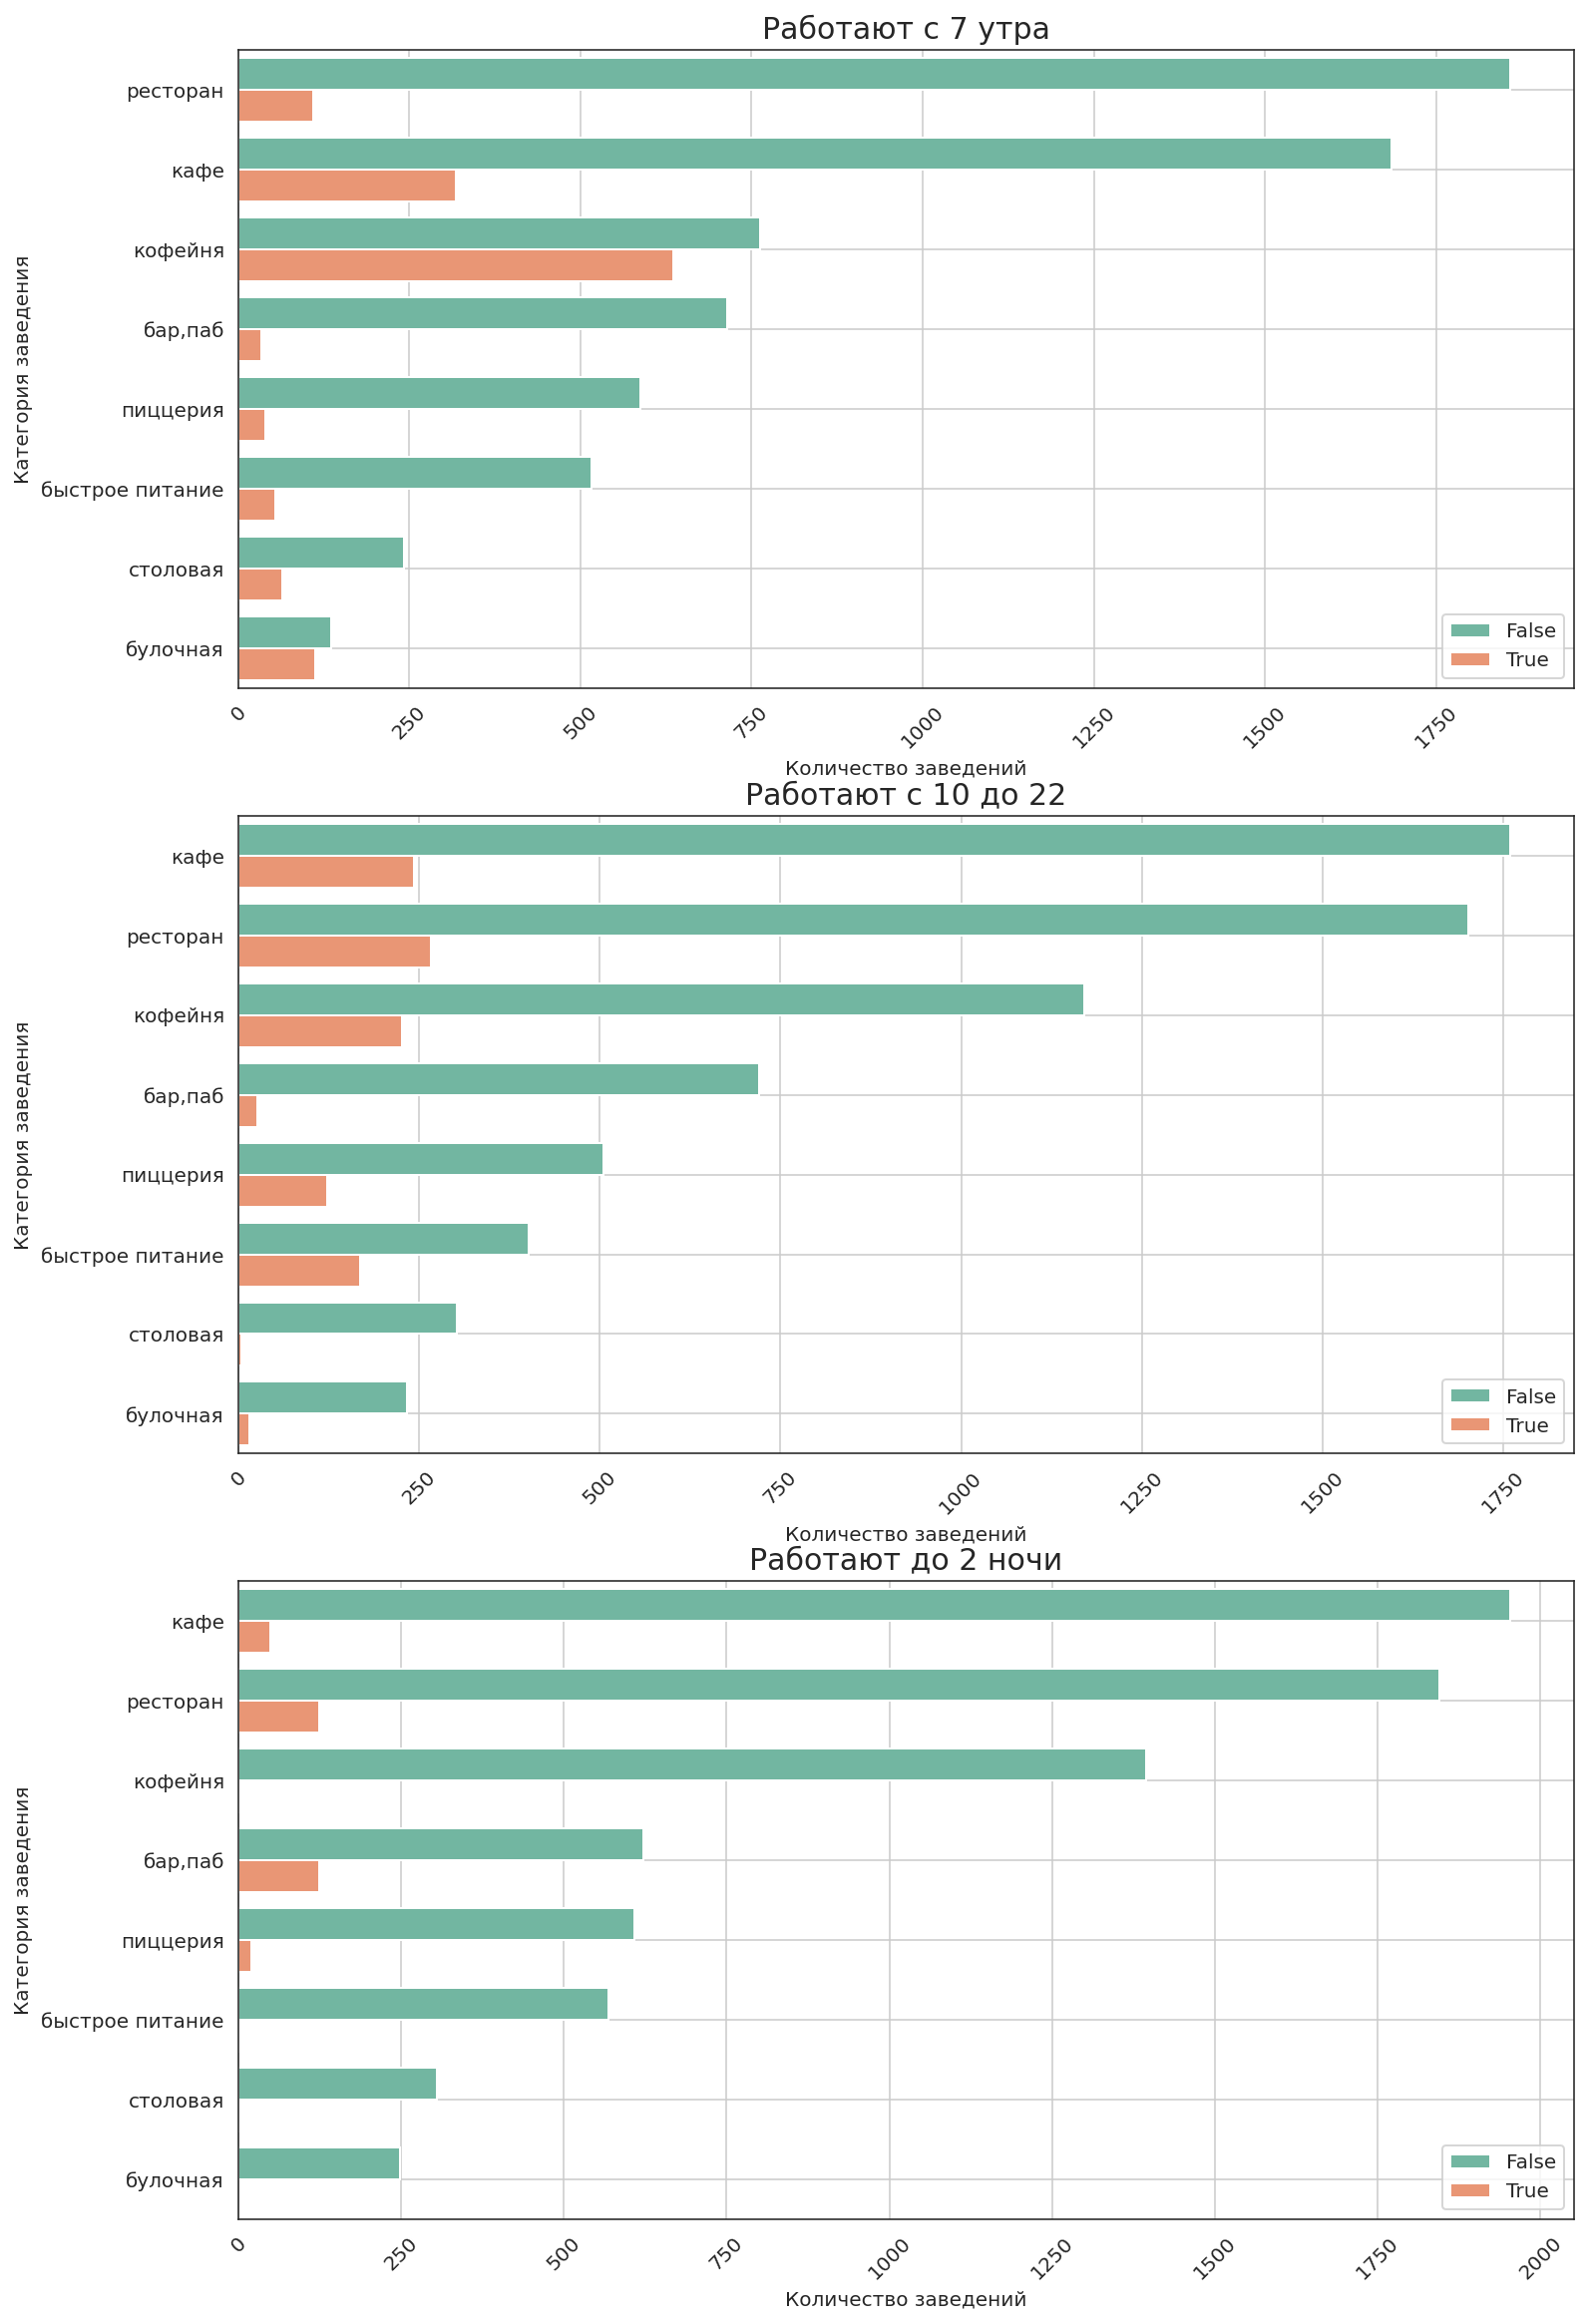

In [135]:
data_mn = daytime.groupby(['category', 'morning'], \
                        as_index = False)[['rating']].count().sort_values(by='rating', ascending=False)

data_tt = daytime.groupby(['category', 'ten_to_ten'], \
                        as_index = False)[['rating']].count().sort_values(by='rating', ascending=False)

data_nt = daytime.groupby(['category', 'night'], \
                        as_index = False)[['rating']].count().sort_values(by='rating', ascending=False)


sns.set_style('white')
fig, axes = plt.subplots(3, 1, figsize=(12, 20))

plt.subplot(3, 1, 1)
# строим столбчатый график средствами seaborn
sns.barplot(x='rating', y='category', data=data_dt, hue='morning', palette="Set2")
# формируем заголовок графика и подписи осей средствами matplotlib
plt.title('Работают с 7 утра', fontsize = 15)
plt.xlabel('Количество заведений')
plt.ylabel('Категория заведения')
# поворачиваем подписи значений по оси X на 45 градусов
plt.xticks(rotation=45)
# выбираем положение легенды и указываем размер шрифта
plt.legend(loc='lower right', fontsize=10)
# добавляем сетку
plt.grid()

plt.subplot(3, 1, 2)
# строим столбчатый график средствами seaborn
sns.barplot(x='rating', y='category', data=data_tt, hue='ten_to_ten', palette="Set2")
# формируем заголовок графика и подписи осей средствами matplotlib
plt.title('Работают с 10 до 22', fontsize = 15)
plt.xlabel('Количество заведений')
plt.ylabel('Категория заведения')
# поворачиваем подписи значений по оси X на 45 градусов
plt.xticks(rotation=45)
# выбираем положение легенды и указываем размер шрифта
plt.legend(loc='lower right', fontsize=10)
# добавляем сетку
plt.grid()

plt.subplot(3, 1, 3)
# строим столбчатый график средствами seaborn
sns.barplot(x='rating', y='category', data=data_nt, hue='night', palette="Set2")
# формируем заголовок графика и подписи осей средствами matplotlib
plt.title('Работают до 2 ночи', fontsize = 15)
plt.xlabel('Количество заведений')
plt.ylabel('Категория заведения')
# поворачиваем подписи значений по оси X на 45 градусов
plt.xticks(rotation=45)
# выбираем положение легенды и указываем размер шрифта
plt.legend(loc='lower right', fontsize=10)
# добавляем сетку
plt.grid()

# отображаем график на экране
plt.show()

По графикам видно, что:
* Среди заведений раньше всех свои двери чаще всего открывают Кафе и кофейни. В основном в каждой категории найдутся заведения, работающие рано. Даже некоторые бары и пабы ждут гостей с семи утра. 
* Хотя в таблице визуально чаще всего втречался график с 10 до 22, по факту в большинстве своем это не совпало с ожиданиями. Не зря в датасете 1307 уникальных комбинаций
* Не все категории заведений работают до двух ночи. Чаще всего до двух ночи работают рестораны и бары

### Выводы <a class="anchor" id="results"></a>

* На рынке общепита Москвы доминируют: Кафе (2378), Рестораны (2043), Кофейни(1413)
* Реже всего встречаются: Столовые (315), Булочные(256)
* Среди заведений Москвы 38,1% рынка принадлежит сетевым заведениям и 61,9% индивидуальным рестораторам (3205 против 5201).
* Шоколадница самый крупный сетевой бренд с долей в 15,5% и 119 заведениями. Так же в тройку попали две пиццерии: Доминосс Пицца (76 заведений) и Додо пицца (74 заведения)
* Наибольшее количество заведений находится в ЦАО. Там открытов более чем в два раза больше точек общепита
* Во всех районах, кроме ЦАО, лидируют кафе. В ЦАО на первом месте по категориям находятся рестораны. Распределение заведений по категориям так же практически везде одинаковое. 
* Больше всего заведений общепита расположились на проспекте Мира 14,6 % (184 заведения).
* Нет оснований полагать что количество заведений общепита растет вместе с длинной улицы
* В большинстве своем, за исключенем пиццерий, сетевые заведения обходят стороной маленьуие улочки. Малый бизнес и локальные ресторатоы доминируют в этом срезе, в особенности в сегменте Кафе

## Детализация исследования: открытие кофейни <a class="anchor" id="coffee"></a> 

Основателям фонда «Shut Up and Take My Money» мечтают — открыть такую же крутую и доступную, как "Central Perk" из сериала "Друзья", кофейню в Москве. Основатели не боятся конкуренции в этой сфере. Определим как обстаят дела с кофейнями в Москве, ограничив датасет до одной категории.

### Кофейни Москвы  <a class="anchor" id="coffee_msc"></a>

In [38]:
coffee = data.query('category == "кофейня"').sort_values(by='name', ascending=True)
print('В Москве всего',len(coffee.index), 'кофеен')

В Москве всего 1413 кофеен


In [39]:
coffee_per_region = coffee.groupby(['district'], as_index = False)[['rating']].count().sort_values(by='rating', ascending=False)

# строим столбчатую диаграмму 
fig = px.bar(coffee_per_region.sort_values(by='rating', ascending=True), # загружаем данные и заново их сортируем
             x='rating', # указываем столбец с данными для оси X
             y='district', # указываем столбец с данными для оси Y
             text='rating'
                                       
            )
# оформляем график
fig.update_layout(title='Количество кофеен в округах Москвы',
                   xaxis_title='Количество кофеен',
                   yaxis_title='Округ')
fig.show() # выводим график

In [40]:
# moscow_lat - широта центра Москвы, moscow_lng - долгота центра Москвы
moscow_lat, moscow_lng = 55.751244, 37.618423

# создаём карту Москвы
m = Map(location=[moscow_lat, moscow_lng], zoom_start=10, tiles='Stamen Terrain')
# создаём пустой кластер, добавляем его на карту
marker_cluster = MarkerCluster().add_to(m)

# пишем функцию, которая принимает строку датафрейма,
# создаёт маркер в текущей точке и добавляет его в кластер marker_cluster
def create_clusters(row):
    
    # это путь к файлу на сервере icons8
    icon_url = 'https://icons8.com/icon/67956/cafe'  
    # создаём объект с собственной иконкой размером 30x30
    icon = CustomIcon(icon_url, icon_size=(30, 30))
    
    Marker(
        [row['lat'], row['lng']],
        popup=f"{row['name']} {row['rating']} {row['hours']}",
    ).add_to(marker_cluster)

# применяем функцию create_clusters() к каждой строке датафрейма
coffee.apply(create_clusters, axis=1)

# выводим карту
m

* Наибольшее количество кофеен расположено в центре Москвы. Чем дальше удаленность от центра, тем меньше кофеен. 
* Большинство заведений распологаются недалеко от перекрестков или рядом с местом массового отдыха (Парки, Торговые центры, набережные) 

Посмотрим на карте где в основном располагаются круглосуточные кофейни

In [41]:
coffee_24 = coffee.query('is_24_7 == True').sort_values(by='name', ascending=True)
print('В Москве всего',len(coffee_24.index), 'круглосуточных кофеен, из них:')

coffee_24_per_region = coffee_24.groupby(['district'],
                                      as_index = False)[['rating']].count().sort_values(by='rating', ascending=False)

# строим столбчатую диаграмму 
fig = px.bar(coffee_24_per_region.sort_values(by='rating', ascending=True), # загружаем данные и заново их сортируем
             x='rating', # указываем столбец с данными для оси X
             y='district', # указываем столбец с данными для оси Y
             text='rating'
                                       
            )
# оформляем график
fig.update_layout(title='Количество круглосуточных кофеен в округах Москвы',
                   xaxis_title='Количество кофеен',
                   yaxis_title='Округ')
fig.show() # выводим график

В Москве всего 59 круглосуточных кофеен, из них:


In [42]:
# moscow_lat - широта центра Москвы, moscow_lng - долгота центра Москвы
moscow_lat, moscow_lng = 55.751244, 37.618423

# создаём карту Москвы
m = Map(location=[moscow_lat, moscow_lng], zoom_start=10, tiles='Stamen Terrain')
# создаём пустой кластер, добавляем его на карту
marker_cluster = MarkerCluster().add_to(m)

# пишем функцию, которая принимает строку датафрейма,
# создаёт маркер в текущей точке и добавляет его в кластер marker_cluster
def create_clusters(row):
    
    # это путь к файлу на сервере icons8
    icon_url = 'https://icons8.com/icon/67956/cafe'  
    # создаём объект с собственной иконкой размером 30x30
    icon = CustomIcon(icon_url, icon_size=(30, 30))
    
    Marker(
        [row['lat'], row['lng']],
        popup=f"{row['name']} {row['rating']} {row['hours']}",
    ).add_to(marker_cluster)
    
# применяем функцию create_clusters() к каждой строке датафрейма
coffee_24.apply(create_clusters, axis=1)

# выводим карту
m

Круглосуточных кофеен в Москве так же достаточно мало. В основном они расположены в центре города. 

In [43]:
rating_coffee = coffee.groupby('district', as_index=False)['rating'].agg('median')

moscow_lat, moscow_lng = 55.751244, 37.618423

# создаём карту Москвы
m = Map(location=[moscow_lat, moscow_lng], zoom_start=10)

Choropleth(
    geo_data=state_geo,
    data=rating_coffee,
    columns=['district', 'rating'],
    key_on='feature.name',
    fill_color='YlGn',
    fill_opacity=0.8,
    legend_name='Медианный рейтинг кофеен по районам',
).add_to(m)

# выводим карту
m

Медианные рейтинги кофеен достаточно высоки, от 4,20 до 4,30. Самый низкий рейтинг в Западном АО

Посмотрим на какую стоимость чашки капучино можно ориентироваться при открытии заведения. Поскольку данные содержали пропуски заполним их в усеченном датасете нулями.

In [44]:
capuchino_cup = coffee.groupby('district', as_index=False)['middle_coffee_cup'].agg('median')

capuchino_cup = capuchino_cup.fillna(0)

moscow_lat, moscow_lng = 55.751244, 37.618423

# создаём карту Москвы
m = Map(location=[moscow_lat, moscow_lng], zoom_start=10)

Choropleth(
    geo_data=state_geo,
    data=capuchino_cup,
    columns=['district', 'middle_coffee_cup'],
    key_on='feature.name',
    fill_color='YlGn',
    fill_opacity=0.8,
    legend_name='Медианный рейтинг кофеен по районам',
).add_to(m)

# выводим карту
m

Во всех районах присутствует информация о стоимости кружки капучино. Самая дешевая кружка в среднем обойдется в 135 рублей, а дорогая 200. 

### Рекомендации по открытию  <a class="anchor" id="open_tips"></a>

После детального изучения кофеен Москвы, рекомендую следующее:
* Подумать об открытии в Северном или Северо-восточном районе так как количество кофеен в этих районах оптимально для здоровой конкуренции
* Тенденция на открытие кофеен, в соответствие с картой распределения, показывает, что большинство заведений находятся рядом с перекрестками и общественными местами. Оптимально было бы найти места, рядом с парком или учебными заведениями
* Есть смысл рассмотреть открытие заведения на небольшой улице, переулке тк сетевые кофейни в таких местах редко открывают
* При выборе рекомендуемых районов можно ориентироваться на среднюю стоимость чашки капучино, в размере 160 - 180 рублей


В дополнение к рекомендациям, прилагаю геолокацию с меткой на Гончаровском парке, так как вокруг него нет открытых кофеен в пешей доступности, при этом вокруг находятся институты, школы, общежития. Самое то, для Московского "Central Parka"

In [45]:
import folium

# сохраняем координаты Большого театра в переменные
point_lat, point_lng = 55.815311, 37.588037

# создаём карту с центром в точке расположения Большого театра и начальным зумом 17
m = folium.Map(location=[point_lat, point_lng], zoom_start=17)
# создаём маркер в точке расположения Большого театра
marker = folium.Marker([point_lat, point_lng])
# добавляем маркер на карту
marker.add_to(m)

m

## Заключение <a class="anchor" id="final"></a> 

Презентация: <https://disk.yandex.ru/i/vgWebBNwsjR4fQ>

Для целей анализа был использован датасет с заведениями общественного питания Москвы, составленный на основе данных сервисов Яндекс Карты и Яндекс Бизнес на лето 2022 года (moscow_places.csv). Информация, размещённая в сервисе Яндекс Бизнес, могла быть добавлена пользователями или найдена в общедоступных источниках. Она носит исключительно справочный характер

В ходе подготовки к исследованию, была проведена следующая предобработка:
* Проведена проверка на Явные дубликаты. Не обнаружены
* Проверены колонки с пропущенными значениями. Оснований для их заполнение какой либо другой инормацией нет
* Добавлены столбцы street с названиями улиц из столбца с адресом и is_24_7 с обозначением, что заведение работает ежедневно и круглосуточно (24/7). 

Заведения были поделены на 8 категорий: 'кафе', 'ресторан', 'кофейня', 'пиццерия', 'бар,паб','быстрое питание', 'булочная' и 'столовая'. Не смотря на то, что кафе и кофейня могут быть похожими словами по смыслу, в классификации заведений общественного питания они разделены (https://restoplace.cc/blog/zavedeniya-horeca#rec520577366). Оставили категории в том виде, в котром они есть

Основные выводы по анализу рынка общепита представленны в пункте [Выводы](#results)

Заказчик - фонд «Shut Up and Take My Money» -  запросил более детальный анализ кофеен москвы, чтобы определить где открыть кофейню, в стиле сериала "Друзья".  

**В Москве всего 2378 кофеен, из них 267 - круглосуточные. Среди них:**

* Больше всего кофеен открыто в Центральном административном районе (464 объекта)
* Меньше всего кофеен открыто в Северо-заподоном административном районе (115 объектов)
* В остальных районах количество кофеет колеблется от 230 до 280 объектов
* Большинство заведений распологаются недалеко от перекрестков или рядом с местом массового отдыха (Парки, Торговые центры, набережные) 

Медианные рейтинги кофеен достаточно высоки, от 4,20 до 4,30. Самый низкий рейтинг в Западном АО

Из всей Москвы только у трех районов была информация о стоимости кружки капучино. Самая дешевая в среднем обойдется в 135 рублей, а дорогая 200. 

**По результатам работы были даны рекомендации, представленные в пункте [Рекомендации по открытию](#open_tips)**

Благодарю за внимание!